In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation, merge
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn import datasets
from matplotlib.cm import get_cmap
from sklearn.metrics import explained_variance_score
#from dataloader import load_visualize_data

import plotly.offline as offline
offline.init_notebook_mode()

import h5py 

Using TensorFlow backend.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
plt.style.use('seaborn-notebook')
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,'xtick.labelsize':14, 'ytick.labelsize':14})

In [4]:
#エンコード　した二つのlatent_dimesionのベクトルからランダムサンプリングする関数を作る。
def sampling(args):

    import tensorflow as tf
    z_mean, z_log_var = args  #argsはkerasのラムダ関数を必要とする

    epsilon = K.random_normal(shape=tf.shape(z_mean),mean=0.,stddev=epsilon_std) #正規分布に従うランダムな要素を持つテンソルを作成

    #潜在的ベクトルは決定的でなく微分可能である
    z = z_mean + K.exp(z_log_var / 2)*epsilon #イプシロンが作用していることで
    return z

In [5]:
#トレーニングを実行し学習するカスタムレイヤーをクラスで定義
class CustomVariationalLayer(Layer): #class クラス名(基底クラス名): で派生クラスの定義

    def __init__(self,**kwargs):
        self.is_placehoder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)     #super().__init__() で基底クラスを継承

    def vae_loss(self,x_input,x_decoded): #損失を計算する関数
        recoxstruction_loss = original_dim * metrics.binary_crossentropy(x_input,x_decoded)
        kl_loss = -0.5 * K.sum(1+z_log_var_encoded - K.square(z_mean_encoded) - K.exp(z_log_var_encoded),axis=-1)
        return K.mean(recoxstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self,inputs): #
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x,x_decoded)
        self.add_loss(loss,inputs=inputs)
        return x 

In [6]:
#ウォームアップを実行する
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # それぞれのエポックでの挙動
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [7]:
np.random.seed(123) #?

In [2]:
##RNA-seqデータを読み込む
import os
import pandas as pd
rnaseq_file = os.path.join('/Users/yokosaka/Desktop/python/1_54rnaseqdata.txt')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df

(2544, 23460)


1/2-SBSRNA4  A1BG  A1BG-AS1      A1CF  A2LD1       A2M  A2ML1  \
GSM2171880_21          0.0   0.0       0.0  0.000000    0.0  0.000000    0.0   
GSM2171881_21          0.0   0.0       0.0  0.000000    0.0  0.000000    0.0   
GSM2171882_21          0.0   0.0       0.0  0.194198    0.0  0.000000    0.0   
GSM2171883_21          0.0   0.0       0.0  0.184346    0.0  0.000000    0.0   
GSM2171884_21          0.0   0.0       0.0  0.000000    0.0  0.000000    0.0   
...                    ...   ...       ...       ...    ...       ...    ...   
GSM2174421_22          0.0   0.0       0.0  0.000000    0.0  0.714411    0.0   
GSM2174422_22          0.0   0.0       0.0  0.000000    0.0  0.000000    0.0   
GSM2174423_22          0.0   0.0       0.0  0.000000    0.0  0.926337    0.0   
GSM2174424_22          0.0   0.0       0.0  0.486101    0.0  0.000000    0.0   
GSM2174425_22          0.0   0.0       0.0  0.000000    0.0  0.000000    0.0   

               A2MP1  A4GALT  A4GNT  ...  ZWINT  ZXDA      ZXDB      ZXDC  \
GSM2171880_21    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   
GSM2171881_21    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   
GSM2171882_21    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   
GSM2171883_21    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   
GSM2171884_21    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   
...              ...     ...    ...  ...    ...   ...       ...       ...   
GSM2174421_22    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.297949   
GSM2174422_22    0.0     0.0    0.0  ...    0.0   0.0  0.187168  0.000000   
GSM2174423_22    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   
GSM2174424_22    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.551846   
GSM2174425_22    0.0     0.0    0.0  ...    0.0   0.0  0.000000  0.000000   

               ZYG11A    ZYG11B       ZYX     ZZEF1      ZZZ3  tAKR  
GSM2171880_21     0.0  0.000000  0.000000  0.000000  0.691083   0.0  
GSM2171881_21     0.0  0.580870  0.154205  0.000000  0.516028   0.0  
GSM2171882_21     0.0  0.000000  0.000000  0.000000  0.000000   0.0  
GSM2171883_21     0.0  0.000000  0.216112  0.478296  0.344458   0.0  
GSM2171884_21     0.0  0.686167  0.000000  0.000000  0.000000   0.0  
...               ...       ...       ...       ...       ...   ...  
GSM2174421_22     0.0  0.000000  0.000000  0.000000  0.000000   0.0  
GSM2174422_22     0.0  0.503646  0.000000  0.000000  0.000000   0.0  
GSM2174423_22     0.0  0.000000  0.462174  0.000000  0.000000   0.0  
GSM2174424_22     0.0  0.000000  0.263048  0.440787  0.000000   0.0  
GSM2174425_22     0.0  0.000000  0.000000  0.000000  0.000000   0.0  

[2544 rows x 23460 columns]

In [16]:
rnaseq_df["ARL6IP6"]

GSM2171880_21    0.47011
GSM2171881_21    0.00000
GSM2171882_21    0.00000
GSM2171883_21    0.00000
GSM2171884_21    0.47273
                  ...   
GSM2174421_22    0.00000
GSM2174422_22    0.00000
GSM2174423_22    0.00000
GSM2174424_22    0.00000
GSM2174425_22    0.00000
Name: ARL6IP6, Length: 2544, dtype: float64

In [9]:
rnaseq_df_label = rnaseq_df

age_label =[]

for i in rnaseq_df.index:
    age_label.append(i[-2:])
    
age_label

['21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',
 '21',

In [10]:
age_label = pd.DataFrame(age_label,index = rnaseq_df.index,columns = ["age_label"])

In [11]:
age_label["age_label"] = age_label["age_label"].replace("^0","",regex = True)

In [12]:
age_label = age_label.astype("float")

In [17]:
for i in list(age_label["age_label"].unique()):
    print(type(i))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [18]:
#age_label.index = rnaseq_df.index

age_label

age_label
GSM2171880_21       21.0
GSM2171881_21       21.0
GSM2171882_21       21.0
GSM2171883_21       21.0
GSM2171884_21       21.0
GSM2171885_21       21.0
GSM2171886_21       21.0
GSM2171887_21       21.0
GSM2171888_21       21.0
GSM2171889_21       21.0
GSM2171890_21       21.0
GSM2171891_21       21.0
GSM2171892_21       21.0
GSM2171893_21       21.0
GSM2171894_21       21.0
GSM2171895_21       21.0
GSM2171896_21       21.0
GSM2171897_21       21.0
GSM2171898_21       21.0
GSM2171899_21       21.0
GSM2171900_21       21.0
GSM2171901_21       21.0
GSM2171902_21       21.0
GSM2171903_21       21.0
GSM2171904_21       21.0
GSM2171905_21       21.0
GSM2171906_21       21.0
GSM2171907_21       21.0
GSM2171908_21       21.0
GSM2171909_21       21.0
...                  ...
GSM2174396_22       22.0
GSM2174397_22       22.0
GSM2174398_22       22.0
GSM2174399_22       22.0
GSM2174400_22       22.0
GSM2174401_22       22.0
GSM2174402_22       22.0
GSM2174403_22       22.0
GSM2174404_22       22.0
GSM2174405_22       22.0
GSM2174406_22       22.0
GSM2174407_22       22.0
GSM2174408_22       22.0
GSM2174409_22       22.0
GSM2174410_22       22.0
GSM2174411_22       22.0
GSM2174412_22       22.0
GSM2174413_22       22.0
GSM2174414_22       22.0
GSM2174415_22       22.0
GSM2174416_22       22.0
GSM2174417_22       22.0
GSM2174418_22       22.0
GSM2174419_22       22.0
GSM2174420_22       22.0
GSM2174421_22       22.0
GSM2174422_22       22.0
GSM2174423_22       22.0
GSM2174424_22       22.0
GSM2174425_22       22.0

[2544 rows x 1 columns]

In [19]:
#age_label = pd.Series(age_label)
#age_label.index = rnaseq_df.index
#age_label.columns = ["age_label"]


rnaseq_df_label = pd.concat([rnaseq_df_label,age_label],axis = 1)
rnaseq_df_label

1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1       A2M  \
GSM2171880_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171881_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171882_21     0.000000  0.000000  0.000000  0.194198  0.000000  0.000000   
GSM2171883_21     0.000000  0.000000  0.000000  0.184346  0.000000  0.000000   
GSM2171884_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171885_21     0.000000  0.000000  0.000000  0.500131  0.000000  0.108087   
GSM2171886_21     0.282701  0.000000  0.000000  0.378663  0.000000  0.000000   
GSM2171887_21     0.464371  0.000000  0.209386  0.404678  0.000000  0.000000   
GSM2171888_21     0.000000  0.000000  0.000000  0.250909  0.000000  0.000000   
GSM2171889_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171890_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171891_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171892_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171893_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171894_21     0.000000  0.000000  0.000000  0.359306  0.000000  0.000000   
GSM2171895_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171896_21     0.000000  0.000000  0.000000  0.300484  0.000000  0.000000   
GSM2171897_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171898_21     0.000000  0.000000  0.000000  0.363729  0.000000  0.000000   
GSM2171899_21     0.000000  0.000000  0.000000  0.593239  0.000000  0.000000   
GSM2171900_21     0.000000  0.000000  0.000000  0.504963  0.000000  0.000000   
GSM2171901_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171902_21     0.000000  0.000000  0.000000  0.395793  0.000000  0.000000   
GSM2171903_21     0.333762  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171904_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171905_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171906_21     0.000000  0.000000  0.000000  0.156571  0.000000  0.000000   
GSM2171907_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2171908_21     0.000000  0.000000  0.117197  0.000000  0.000000  0.000000   
GSM2171909_21     0.000000  0.000000  0.000000  0.166024  0.000000  0.000000   
...                    ...       ...       ...       ...       ...       ...   
GSM2174396_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174397_22     0.000000  0.346068  0.000000  0.364040  0.000000  0.000000   
GSM2174398_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174399_22     0.000000  0.379959  0.000000  0.424480  0.000000  0.000000   
GSM2174400_22     0.000000  0.000000  0.000000  0.543452  0.000000  0.000000   
GSM2174401_22     0.000000  0.415733  0.000000  0.291361  0.000000  0.000000   
GSM2174402_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.857231   
GSM2174403_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174404_22     0.000000  0.360640  0.000000  0.450694  0.000000  0.000000   
GSM2174405_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.677700   
GSM2174406_22     0.000000  0.407388  0.307394  0.000000  0.181951  0.000000   
GSM2174407_22     0.000000  0.311215  0.000000  0.000000  0.000000  0.000000   
GSM2174408_22     0.000000  0.000000  0.000000  0.512111  0.000000  0.000000   
GSM2174409_22     0.000000  0.000000  0.000000  0.267139  0.000000  0.000000   
GSM2174410_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174411_22     0.000000  0.000000  0.000000  0.373960  0.000000  0.000000   
GSM2174412_22     0.000000  0.220970  0.000000  0.000000  0.000000  0.000000   
GSM2174413_22     0.000000  0.000000  0.000000  0.499414  0.000000  0.000000   
GSM2174414_22  

In [20]:
#age_labelに年齢データが格納されている
age_label.columns = ["age_label"]

In [21]:
rnaseq_df_columns = rnaseq_df.columns 
rnaseq_df_columns = list(rnaseq_df_columns) +["age_label"]

In [22]:
rnaseq_df_label.columns = rnaseq_df_columns


In [23]:
rnaseq_df_label["age_label"].unique()

array([ 21.,  38.,   1.,   5.,  44.,   6.,  54.,  22.])

In [24]:
#xのトレーニング・テストデータの作成
#データの10%をテストデータセットに分割する
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)

rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

In [25]:
rnaseq_test_df

1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1       A2M  \
GSM2173584_05     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173026_44     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174402_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.857231   
GSM2172710_38     0.000000  0.000000  0.000000  0.288353  0.000000  0.000000   
GSM2173914_54     0.000000  0.381941  0.000000  0.300175  0.000000  0.000000   
GSM2173451_05     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173351_44     0.000000  0.360964  0.000000  0.320460  0.000000  0.000000   
GSM2172064_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172465_38     0.000000  0.000000  0.000000  0.000000  0.000000  0.209043   
GSM2173546_05     0.000000  0.258086  0.000000  0.000000  0.000000  0.747071   
GSM2172922_05     0.000000  0.488715  0.000000  0.000000  0.000000  0.000000   
GSM2174360_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172794_01     0.000000  0.286147  0.000000  0.504610  0.000000  0.000000   
GSM2174151_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172297_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172507_38     0.000000  0.448909  0.000000  0.332018  0.000000  0.000000   
GSM2173771_01     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173263_06     0.000000  0.424916  0.000000  0.000000  0.000000  0.000000   
GSM2172885_38     0.000000  0.348687  0.000000  0.000000  0.000000  0.000000   
GSM2173261_06     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172496_38     0.147634  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174012_54     0.000000  0.389990  0.000000  0.000000  0.000000  0.000000   
GSM2172942_44     0.000000  0.453106  0.320759  0.553021  0.000000  0.000000   
GSM2171913_21     0.000000  0.149958  0.000000  0.149958  0.000000  0.000000   
GSM2172766_01     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173642_05     0.000000  0.000000  0.000000  0.000000  0.199603  0.000000   
GSM2172275_21     0.000000  0.000000  0.267022  0.000000  0.000000  0.000000   
GSM2174304_22     0.000000  0.316372  0.000000  0.000000  0.000000  0.000000   
GSM2173846_01     0.000000  0.425267  0.000000  0.000000  0.000000  0.000000   
GSM2174148_22     0.000000  0.148689  0.000000  0.000000  0.000000  0.000000   
...                    ...       ...       ...       ...       ...       ...   
GSM2174143_22     0.000000  0.375730  0.000000  0.000000  0.000000  0.110285   
GSM2174329_22     0.374071  0.172361  0.000000  0.346108  0.000000  0.000000   
GSM2174173_22     0.000000  0.280644  0.165435  0.000000  0.000000  0.000000   
GSM2173060_05     0.000000  0.000000  0.000000  0.000000  0.000000  0.659661   
GSM2173433_05     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173347_44     0.000000  0.000000  0.000000  0.376171  0.000000  0.000000   
GSM2173986_54     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174132_54     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172888_38     0.000000  0.000000  0.000000  0.287841  0.000000  0.000000   
GSM2173088_44     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173653_05     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2174218_22     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172282_21     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2173184_06     0.000000  0.473695  0.000000  0.000000  0.000000  0.000000   
GSM2172751_38     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GSM2172199_21     0.000000  0.000000  0.000000  0.000000  0.225383  0.000000   
GSM2172427_38     0.000000  0.238938  0.000000  0.000000  0.000000  0.708222   
GSM2173960_54     0.000000  0.439591  0.000000  0.000000  0.000000  0.000000   
GSM2173396_05  

In [26]:
#yのトレーニング・テストデータの作成
rnaseq_test_df_index = list(rnaseq_test_df.index)
y_label_test = age_label.loc[rnaseq_test_df_index]
y_label_train = age_label.drop(rnaseq_test_df.index)

#ラベルyの先頭の0を削除する


In [27]:
##変数とハイパーパラメーターを初期化
#ハイパーパラメーターの初期化
original_dim = rnaseq_df.shape[1]
latent_dim = 100 #潜在特徴ベクトルの次元を設定

batch_size = 50  #バッチサイズ
epochs = 50 #エポック数
learning_rate = 0.0005 #学習率

epsilon_std = 1.0 #イプシロンの標準偏差を1にする
beta = K.variable(0) #成分が0の0テンソル   #betaはKL lossn
kappa = 1#カッパは学習に影響していなかった

In [28]:
##エンコーダー
#プレイスホルダーにRNA-seqデータをインプットする
rnaseq_input = Input(shape=(original_dim, )) #Input(shape= ,)で入力層の数を定義
y_label_input = Input(shape=(1,))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

#まーじが使えない可能性がある
#merged_encode = merge([rnaseq_input,y_label_input],mode='concat')
merged_encode = keras.layers.concatenate([rnaseq_input,y_label_input], axis=-1)

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(merged_encode) #input層から中間層への全結合ニューラルネット
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear) #input層から入ってくるデータを正規化
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm) #中間層に入っていくデータを"relu関数"で活性化する

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(merged_encode)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded]) #上で定義したsamplingクラスをz_mean_encodedと
#z_log_var_encodedを引数として作用させ、デコーダーへと出力する。

#zが潜在変数を示しているのではないのか??


In [29]:
##デコーダー
# The decoding layer is much simpler with a single layer and sigmoid activation

#マージは使えなかった
#merged_decode = merge([z,ylabel_input],mode='concat')
merged_decode = keras.layers.concatenate([z,y_label_input], axis=-1)

decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid') #デコーダーへの出力は"シグモイド関数"で活性化される
rnaseq_reconstruct = decoder_to_reconstruct(merged_decode)

In [30]:
#カスタムバリデーションレーヤーを使わないでこの関数を使うバージョン
def vae_loss(x_input,x_decoded): #損失を計算する関数
        recoxstruction_loss = original_dim * metrics.binary_crossentropy(x_input,x_decoded)
        kl_loss = -0.5 * K.sum(1+z_log_var_encoded - K.square(z_mean_encoded) - K.exp(z_log_var_encoded),axis=-1)
        return K.mean(recoxstruction_loss + (K.get_value(beta) * kl_loss))

In [46]:
#カスタムバリデーションレイヤーを使う場合はこのコード

'''##エンコーダーとデコーダーを繋いでVAEを作る
adam = optimizers.Adam(lr=learning_rate) #optimizer.Adam(lr=学習率) Kerasモデルのコンパイルに必要なオプティマイザーの一つ
cvae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct]) #入力データと出力データの誤差をCustomVariationalLayerで計算
cvae = Model([rnaseq_input,y_label_input], cvae_layer) #Model(入力テンソル、出力テンソル)　で中間に含む層をインスタンス化する
cvae.compile(optimizer=adam, loss=None, loss_weights=[beta]) #compile(optimizer名) でモデルを設定してコンパイルする

cvae.summary()'''

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 23460)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 23461)        0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          2346200     concatenate_2[0][0]              
__________

In [31]:
#カスタムバリデーションレイヤーを使わないで外の損失関数で計算する
adam = optimizers.Adam(lr=learning_rate)
cvae = Model([rnaseq_input,y_label_input],rnaseq_reconstruct )
cvae.compile(optimizer=adam, loss=vae_loss, loss_weights=[beta])


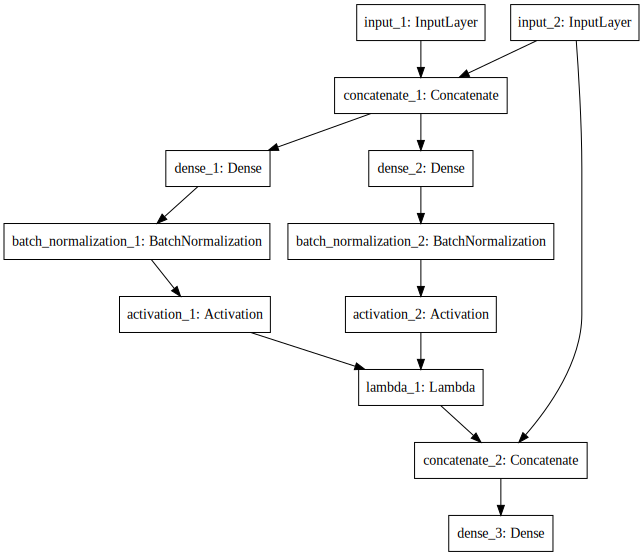

In [32]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_onehidden_cvae_architecture.png')
plot_model(cvae, to_file=output_model_file)

SVG(model_to_dot(cvae).create(prog='dot', format='svg'))

In [33]:
##Train the model
#%%time
hist = cvae.fit([np.array(rnaseq_train_df),np.array(y_label_train)],np.array(rnaseq_train_df),shuffle=True,epochs=epochs,verbose=0,batch_size=batch_size,validation_data=([np.array(rnaseq_test_df),np.array(y_label_test)],np.array(rnaseq_test_df)),callbacks=[WarmUpCallback(beta, kappa),TQDMNotebookCallback(leave_inner=True, leave_outer=True)])






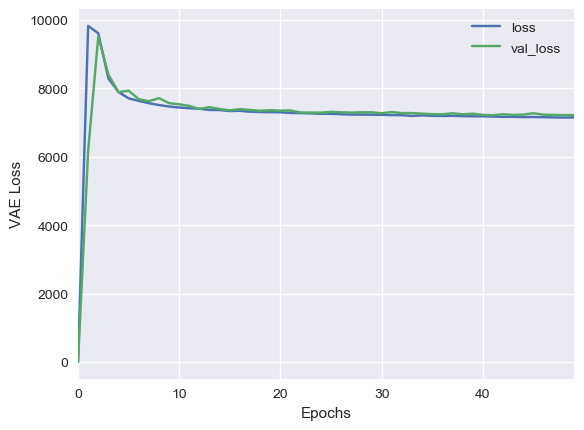

In [34]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('/Users/yokosaka/Desktop/python/','my_onehidden_cvae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [72]:
#y_test,y_predictで誤差関数を定義しているブログもあったためそちらのモデルも考慮してみる
def vae_loss_y(y_true,y_pred): #損失を計算する関数
        recon = K.sum(K.binary_crossentropy(y_true,y_pred),axis = -1)
        kl = 0.5 * K.sum(K.exp(z_log_var_encoded) + K.square(z_mean_encoded) -1. -z_log_var_encoded,axis = -1)
        return recon + kl
        #recoxstruction_loss = original_dim * metrics.binary_crossentropy(x_input,x_decoded)
        #kl_loss = -0.5 * K.sum(1+z_log_var_encoded - K.square(z_mean_encoded) - K.exp(z_log_var_encoded),axis=-1)
        #return K.mean(recoxstruction_loss + (K.get_value(beta) * kl_loss))

In [73]:
cvae_y_pred = Model([rnaseq_input,y_label_input],rnaseq_reconstruct )

In [74]:
cvae_y_pred.compile(optimizer=adam, loss=vae_loss_y, loss_weights=[beta])

In [75]:
cvae_y_pred_hist = cvae_y_pred.fit([np.array(rnaseq_train_df),np.array(y_label_train)],np.array(rnaseq_train_df),shuffle=True,epochs=epochs,verbose=0,batch_size=batch_size,validation_data=([np.array(rnaseq_test_df),np.array(y_label_test)],np.array(rnaseq_test_df)),callbacks=[WarmUpCallback(beta, kappa),TQDMNotebookCallback(leave_inner=True, leave_outer=True)])




In [35]:
##トレーニングしたモデルをコンパイルし出力
##エンコーダーモデル
# Model to compress input
encoder = Model([rnaseq_input,y_label_input], z)

In [36]:
# 隠れ層にrnaseqデータを潜在変数としてエンコードする。
encoded_rnaseq_df = encoder.predict_on_batch([rnaseq_df,age_label])
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq_df.index)
encoded_rnaseq_df

0         1         2         3         4         5   \
GSM2171880_21 -0.575046  1.255785  1.004379 -0.507526  2.585463  0.248104   
GSM2171881_21  0.279838 -0.104298  0.758107  0.249420 -0.016275  1.598673   
GSM2171882_21  2.503466  1.536952  1.027550  0.815052  2.242197  0.297082   
GSM2171883_21  0.657510  1.769376  1.362156 -0.751024 -0.242331  0.496556   
GSM2171884_21 -0.271610 -0.101957 -0.005080 -0.383101  0.630794  2.436635   
GSM2171885_21  0.105661 -0.235774  1.980906  0.376258 -0.755643  1.484972   
GSM2171886_21  0.638087 -0.205591  1.682825  0.686697 -0.059398 -1.739454   
GSM2171887_21  0.596478 -1.066282  1.494184 -0.008801  0.314307  1.073631   
GSM2171888_21  3.604188 -0.634671  1.294150 -0.061677 -0.230594  0.397038   
GSM2171889_21  3.185946  0.443512  0.061532 -0.312469  0.902028  2.629157   
GSM2171890_21  2.360056  0.786730 -0.424581  0.769770  1.521451 -0.095970   
GSM2171891_21  0.365629  0.942186 -1.423128  0.452842 -1.890858  1.695535   
GSM2171892_21 -1.335025  0.929687  1.353449  0.498327 -0.113611  0.721647   
GSM2171893_21  1.224881  1.020166 -0.445334  0.243640  1.460504  3.509737   
GSM2171894_21  1.273211  2.444769  0.827771  1.277231  2.161273  1.929913   
GSM2171895_21 -0.453318  0.343369  0.051081 -0.458867 -2.216646  1.509684   
GSM2171896_21  2.474722 -0.240716  0.863845 -0.529829  0.259176  2.035050   
GSM2171897_21  2.593987  0.389174 -0.515855 -0.862256  1.427559  2.428580   
GSM2171898_21  1.464757  1.823150 -0.824089  0.779088  0.972157  1.268740   
GSM2171899_21  2.300464 -0.775880  0.123242 -1.616893  1.378493  2.895800   
GSM2171900_21  2.185879  2.571480 -0.040318  0.591208  0.447459  2.132231   
GSM2171901_21  1.275247  0.700191  0.912858 -0.203569 -0.340695  1.052155   
GSM2171902_21  0.669333  1.551803 -0.242774  1.533041 -0.215689  2.323597   
GSM2171903_21 -0.626488  1.606884  2.531240 -0.976174 -1.293686  2.315879   
GSM2171904_21  2.335326 -1.477526 -0.323496  0.944777  0.025560  1.459346   
GSM2171905_21 -0.196444  1.003257 -0.138855  1.326834  0.503946  2.137176   
GSM2171906_21 -0.385981  1.439708  2.719650  1.310607 -1.388514  0.474368   
GSM2171907_21 -0.484619 -0.157062  1.417732 -1.520676 -2.558420 -0.199714   
GSM2171908_21 -0.944631  0.882868 -0.375414  1.443364  0.877068 -0.112391   
GSM2171909_21  1.591491  1.059777 -1.000617  0.159898  2.194850  1.105216   
...                 ...       ...       ...       ...       ...       ...   
GSM2174396_22  0.152169  1.757052  1.710454  1.752599  1.861237  2.257179   
GSM2174397_22 -1.542236  0.136973  0.996527  0.657389  2.020252  1.613396   
GSM2174398_22 -0.584543  1.752468  4.138252 -0.692832 -0.360049 -0.148562   
GSM2174399_22  0.705251  2.369208  1.727126 -0.113136  0.507202 -0.983243   
GSM2174400_22  0.170139  2.085311  0.482288 -0.981148 -0.005390 -0.128227   
GSM2174401_22 -1.441397 -0.325589  0.938163  0.040439  0.459403 -0.197220   
GSM2174402_22 -0.617933 -1.594008  0.077574  0.750297  1.117657  1.406267   
GSM2174403_22  0.562341  1.759443  0.340023  2.412409  0.653922  2.801935   
GSM2174404_22 -1.183933  1.876188  2.924579  1.806441  0.084430 -0.571759   
GSM2174405_22  1.206986 -0.125830 -0.444775  0.495979  0.621077  4.276243   
GSM2174406_22 -0.020112  3.165625  1.598646 -1.027482 -0.152089 -0.038159   
GSM2174407_22 -0.376933  1.284758 -0.276752  1.194320  3.407704  1.330149   
GSM2174408_22 -0.631853  0.725096 -0.167980 -0.343346  1.706246 -1.489711   
GSM2174409_22  1.870943  0.813830  3.754299 -1.592676  0.093757 -0.810088   
GSM2174410_22  0.518810 -0.150500 -1.558864  0.791904  0.902310 -0.268839   
GSM2174411_22  1.257533  0.759755  2.593225 -0.900819  0.116966  0.584609   
GSM2174412_22 -0.265366  1.351840  3.493555 -1.542511  0.132268  0.978578   
GSM2174413_22  1.185244 -0.227338  2.529410  1.580874  1.397630 -0.843436   
GSM2174414_22 -1.097905  1.913432  2.838989  0.235046  0.410390  0.568977   
GSM2174415_22  0.365786  1.847395 -1.221695 -0.412540  3.358541  1.900986   
GSM2174416_22  0.

In [37]:
encoded_rnaseq_df_1 = encoder.predict_on_batch([rnaseq_df, age_label])
encoded_rnaseq_df_1 = pd.DataFrame(encoded_rnaseq_df_1, index=rnaseq_df.index)
encoded_rnaseq_df_1

0         1         2         3         4         5   \
GSM2171880_21  0.938103  0.293529  1.862126  0.962292  1.018236 -1.681854   
GSM2171881_21 -0.794205  1.658595  0.734387 -1.333085 -0.795144 -0.311284   
GSM2171882_21  0.581458  2.750763 -1.182769  0.200415  0.888696  3.520165   
GSM2171883_21  0.589166  1.100536  0.411760 -0.934310  0.646977 -0.511782   
GSM2171884_21  1.523285 -0.980958  1.783211  2.018304  2.223041  1.549548   
GSM2171885_21  0.481248 -1.899285  2.511295  0.968340  0.147218  0.573288   
GSM2171886_21 -0.726618 -0.728529  1.795188 -0.519256 -0.241911  0.248163   
GSM2171887_21  0.959672 -1.623441  0.532201  0.877367 -1.500215  1.142972   
GSM2171888_21  0.626620  0.707317 -0.266226  0.755918  0.290614  2.189115   
GSM2171889_21  1.941771  1.818476  0.436166 -2.194730  2.578972  2.855211   
GSM2171890_21  0.815963  2.355192 -0.838725 -0.145296  0.116054  1.844159   
GSM2171891_21  1.240597  2.851763  1.921006  0.942845  0.583729  2.844634   
GSM2171892_21 -1.609210 -1.269369  1.170940 -1.291926  0.922116  0.751432   
GSM2171893_21  2.802964  1.579092  0.196500 -2.026671  2.714378  1.757487   
GSM2171894_21  2.024642  1.828096  0.834819 -1.890184  0.676388 -0.207485   
GSM2171895_21  0.806705 -0.245367  0.079571 -0.153951  0.708997  0.943870   
GSM2171896_21  0.910350 -0.125818  1.073638  0.159470 -0.237559  0.982870   
GSM2171897_21  4.187531  0.418002  0.253785 -0.243179 -0.677050  2.667100   
GSM2171898_21  1.101014  1.339350  0.724483  0.497754  0.471137 -0.218993   
GSM2171899_21  0.761396  0.049796  0.263070 -1.321206 -0.635471  1.310129   
GSM2171900_21  1.391165  2.273839  0.190662  1.302255  2.723158  3.573753   
GSM2171901_21  2.144624  0.856164 -0.602297 -1.297255  1.182606  2.283726   
GSM2171902_21 -0.359485  0.602916 -1.661770 -0.145649 -0.217242  1.950775   
GSM2171903_21 -0.251059  0.919035 -0.019684 -0.043164 -0.138705  1.940765   
GSM2171904_21 -0.207227  1.459371  0.023593  0.075890 -0.243609  1.260589   
GSM2171905_21  2.807027  2.230592 -0.997882 -0.926683  2.928940  0.888490   
GSM2171906_21  0.022109 -2.119067  0.479533  1.126180 -0.259622 -1.228198   
GSM2171907_21 -1.244804  1.473748  0.352994  0.150430 -0.752425  1.255118   
GSM2171908_21  0.825712  0.394110  1.282076  0.134506 -0.977012 -1.287520   
GSM2171909_21 -0.362368  0.915893 -0.365724 -1.048522  1.963281  1.439313   
...                 ...       ...       ...       ...       ...       ...   
GSM2174396_22  1.880383  2.092104  1.454610  1.084470  1.777888 -0.953392   
GSM2174397_22  0.444556  0.715775  2.765117 -0.365113  2.404680  1.796128   
GSM2174398_22  1.798661  0.915856  1.493505  0.313308 -1.119877 -0.697601   
GSM2174399_22  0.471547  2.434191  3.010953  1.618459  0.672366 -0.224853   
GSM2174400_22  0.872076  1.242657  1.997977 -0.448215  2.297929  1.352255   
GSM2174401_22  0.641815  1.098973  1.292912 -0.108165  1.013903 -0.102631   
GSM2174402_22  0.102457  0.196124 -1.748673 -0.613358 -1.752532  2.357740   
GSM2174403_22  0.312530  0.328984 -0.499148  0.274849  1.954233  1.536467   
GSM2174404_22 -2.536852  2.360054  2.080475 -0.727694 -0.223503 -1.326885   
GSM2174405_22 -0.599529  2.294947 -1.085864 -2.149989 -0.715149  1.099060   
GSM2174406_22 -0.111802 -0.652640 -1.297532  0.464214  1.209328 -0.165168   
GSM2174407_22 -2.528806  0.973051 -0.017380  0.763662  4.613227  1.039632   
GSM2174408_22 -0.092273  0.243483  1.323252 -0.126412  1.313393  1.360461   
GSM2174409_22 -0.658559  2.846555  2.033870  0.431589 -0.100921  0.660678   
GSM2174410_22  4.275886 -0.114977  0.275557 -0.824638 -0.723101  1.094988   
GSM2174411_22 -1.201245  0.988416  2.843455 -0.268794  1.329523  0.540284   
GSM2174412_22 -0.222389  2.890422  2.694283 -1.817427  0.231342 -0.670226   
GSM2174413_22 -2.071150  0.625843  4.160284 -0.798678 -0.497610 -0.204922   
GSM2174414_22 -0.816784  2.003504  1.735767  1.575934 -0.019763 -0.068842   
GSM2174415_22  2.886960  1.434029 -0.344791 -0.687059  3.576945  3.341354   
GSM2174416_22 -1.

In [38]:
encoded_rnaseq_df_1.columns.name = 'sample_id'
encoded_rnaseq_df_1.columns = encoded_rnaseq_df_1.columns + 1
encoded_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_cvae_1_encoded_rnaseq_onehidden_warmup_batchnorm.tsv')
encoded_rnaseq_df_1.to_csv(encoded_file, sep='\t')
encoded_rnaseq_df_1

sample_id           1         2         3         4         5         6    \
GSM2171880_21  0.938103  0.293529  1.862126  0.962292  1.018236 -1.681854   
GSM2171881_21 -0.794205  1.658595  0.734387 -1.333085 -0.795144 -0.311284   
GSM2171882_21  0.581458  2.750763 -1.182769  0.200415  0.888696  3.520165   
GSM2171883_21  0.589166  1.100536  0.411760 -0.934310  0.646977 -0.511782   
GSM2171884_21  1.523285 -0.980958  1.783211  2.018304  2.223041  1.549548   
GSM2171885_21  0.481248 -1.899285  2.511295  0.968340  0.147218  0.573288   
GSM2171886_21 -0.726618 -0.728529  1.795188 -0.519256 -0.241911  0.248163   
GSM2171887_21  0.959672 -1.623441  0.532201  0.877367 -1.500215  1.142972   
GSM2171888_21  0.626620  0.707317 -0.266226  0.755918  0.290614  2.189115   
GSM2171889_21  1.941771  1.818476  0.436166 -2.194730  2.578972  2.855211   
GSM2171890_21  0.815963  2.355192 -0.838725 -0.145296  0.116054  1.844159   
GSM2171891_21  1.240597  2.851763  1.921006  0.942845  0.583729  2.844634   
GSM2171892_21 -1.609210 -1.269369  1.170940 -1.291926  0.922116  0.751432   
GSM2171893_21  2.802964  1.579092  0.196500 -2.026671  2.714378  1.757487   
GSM2171894_21  2.024642  1.828096  0.834819 -1.890184  0.676388 -0.207485   
GSM2171895_21  0.806705 -0.245367  0.079571 -0.153951  0.708997  0.943870   
GSM2171896_21  0.910350 -0.125818  1.073638  0.159470 -0.237559  0.982870   
GSM2171897_21  4.187531  0.418002  0.253785 -0.243179 -0.677050  2.667100   
GSM2171898_21  1.101014  1.339350  0.724483  0.497754  0.471137 -0.218993   
GSM2171899_21  0.761396  0.049796  0.263070 -1.321206 -0.635471  1.310129   
GSM2171900_21  1.391165  2.273839  0.190662  1.302255  2.723158  3.573753   
GSM2171901_21  2.144624  0.856164 -0.602297 -1.297255  1.182606  2.283726   
GSM2171902_21 -0.359485  0.602916 -1.661770 -0.145649 -0.217242  1.950775   
GSM2171903_21 -0.251059  0.919035 -0.019684 -0.043164 -0.138705  1.940765   
GSM2171904_21 -0.207227  1.459371  0.023593  0.075890 -0.243609  1.260589   
GSM2171905_21  2.807027  2.230592 -0.997882 -0.926683  2.928940  0.888490   
GSM2171906_21  0.022109 -2.119067  0.479533  1.126180 -0.259622 -1.228198   
GSM2171907_21 -1.244804  1.473748  0.352994  0.150430 -0.752425  1.255118   
GSM2171908_21  0.825712  0.394110  1.282076  0.134506 -0.977012 -1.287520   
GSM2171909_21 -0.362368  0.915893 -0.365724 -1.048522  1.963281  1.439313   
...                 ...       ...       ...       ...       ...       ...   
GSM2174396_22  1.880383  2.092104  1.454610  1.084470  1.777888 -0.953392   
GSM2174397_22  0.444556  0.715775  2.765117 -0.365113  2.404680  1.796128   
GSM2174398_22  1.798661  0.915856  1.493505  0.313308 -1.119877 -0.697601   
GSM2174399_22  0.471547  2.434191  3.010953  1.618459  0.672366 -0.224853   
GSM2174400_22  0.872076  1.242657  1.997977 -0.448215  2.297929  1.352255   
GSM2174401_22  0.641815  1.098973  1.292912 -0.108165  1.013903 -0.102631   
GSM2174402_22  0.102457  0.196124 -1.748673 -0.613358 -1.752532  2.357740   
GSM2174403_22  0.312530  0.328984 -0.499148  0.274849  1.954233  1.536467   
GSM2174404_22 -2.536852  2.360054  2.080475 -0.727694 -0.223503 -1.326885   
GSM2174405_22 -0.599529  2.294947 -1.085864 -2.149989 -0.715149  1.099060   
GSM2174406_22 -0.111802 -0.652640 -1.297532  0.464214  1.209328 -0.165168   
GSM2174407_22 -2.528806  0.973051 -0.017380  0.763662  4.613227  1.039632   
GSM2174408_22 -0.092273  0.243483  1.323252 -0.126412  1.313393  1.360461   
GSM2174409_22 -0.658559  2.846555  2.033870  0.431589 -0.100921  0.660678   
GSM2174410_22  4.275886 -0.114977  0.275557 -0.824638 -0.723101  1.094988   
GSM2174411_22 -1.201245  0.988416  2.843455 -0.268794  1.329523  0.540284   
GSM2174412_22 -0.222389  2.890422  2.694283 -1.817427  0.231342 -0.670226   
GSM2174413_22 -2.071150  0.625843  4.160284 -0.798678 -0.497610 -0.204922   
GSM2174414_22 -0.816784  2.003504  1.735767  1.575934 -0.019763 -0.068842   
GSM2174415_22  2.886960  1.434029 -0.344791 -0.687059  3.576945  3.341354

In [39]:
encoder_model_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_encoder_onehidden_vae.hdf5')
encoder.save(encoder_model_file)

In [40]:

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,learning_rate=300, n_iter=400)
tsne_out_2 = tsne.fit_transform(encoded_rnaseq_df_1)
tsne_out_2 = pd.DataFrame(tsne_out_2, columns=['1', '2'])
tsne_out_2.index = encoded_rnaseq_df_1.index

In [41]:
print(tsne_out_2)

                       1          2
GSM2171880_21 -28.125311 -14.666607
GSM2171881_21 -29.768881 -16.474813
GSM2171882_21  12.299287  29.839678
GSM2171883_21 -27.236164 -15.124516
GSM2171884_21 -30.658312 -13.756668
GSM2171885_21 -27.389175 -16.010969
GSM2171886_21 -33.237556  -3.632113
GSM2171887_21 -31.927723  -3.680892
GSM2171888_21  13.122836  29.863945
GSM2171889_21  11.651763  30.832483
GSM2171890_21  13.078914  30.683792
GSM2171891_21  11.441397  30.736584
GSM2171892_21 -32.766792  -4.346966
GSM2171893_21  13.084816  30.682783
GSM2171894_21  13.542825  30.417038
GSM2171895_21 -29.280159 -14.478814
GSM2171896_21  12.932736  32.612999
GSM2171897_21  14.193573  30.940804
GSM2171898_21  14.034663  32.171547
GSM2171899_21  13.987813  31.044851
GSM2171900_21  11.906390  30.580914
GSM2171901_21  13.451160  30.464359
GSM2171902_21 -34.607243  -4.530418
GSM2171903_21 -34.616997  -5.065040
GSM2171904_21 -34.174351  -4.455541
GSM2171905_21  14.578352  30.111694
GSM2171906_21 -29.019417 -14

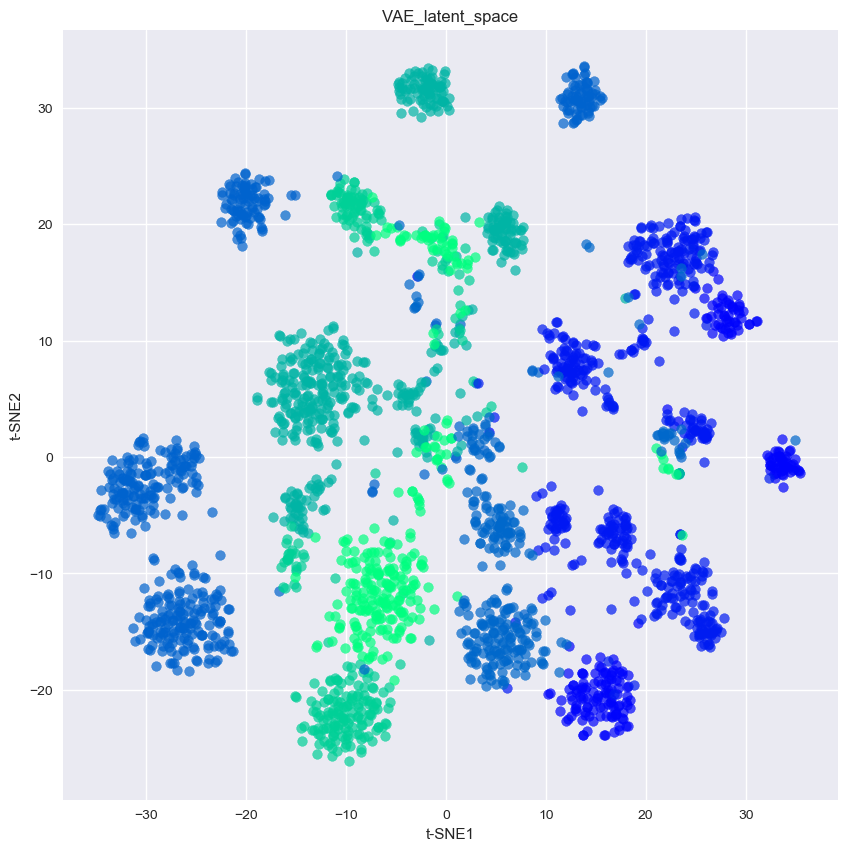

In [42]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('VAE_latent_space')
ax = fig.add_subplot(1,1,1)

ax.scatter(tsne_out_2.iloc[0:505,0], tsne_out_2.iloc[0:505, 1],c = plt.cm.winter(21/54),label = "21year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[505:979,0], tsne_out_2.iloc[505:979, 1],c = plt.cm.winter(38/54),label = "38year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[979:1200,0],tsne_out_2.iloc[979:1200, 1],c = plt.cm.winter(1/54),label = "01year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[1200:1531,0],tsne_out_2.iloc[1200:1531, 1],c = plt.cm.winter(5/54),label = "05year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[1531:1808,0], tsne_out_2.iloc[1531:1808, 1],c = plt.cm.winter(44/54),label = "44year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[1808:1986,0],tsne_out_2.iloc[1808:1986, 1],c = plt.cm.winter(6/54),label = "06year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[1986:2258,0], tsne_out_2.iloc[1986:2258, 1],c = plt.cm.winter(54/54),label = "54year",alpha=0.7)
ax.scatter(tsne_out_2.iloc[2258:len(tsne_out_2),0], tsne_out_2.iloc[2258:len(tsne_out_2), 1],c = plt.cm.winter(22/54),label = "22year",alpha=0.7)
#青から緑色になる程年齢が高くなっていく
#ax.collections[0].colorbar.minorticks_on()

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')


plt.show()

In [43]:
##Decoder (generative) model

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim + 1, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

In [44]:
decoder_model_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_cvae_1decoder_onehidden_vae.hdf5')

In [45]:
decoder.save(decoder_model_file)

In [22]:
#保存したencoded_rnaseq_df_1を読み込む
encoded_rnaseq_df_1 = pd.read_table('/Users/yokosaka/Desktop/python/my_cvae_1_encoded_rnaseq_onehidden_warmup_batchnorm.tsv',index_col = 0)
encoded_rnaseq_df_1.columns = [i for i in range(1,101)]

In [23]:
#保存したdecoderを読み込む
decoder = keras.models.load_model('/Users/yokosaka/Desktop/python/my_cvae_1decoder_onehidden_vae.hdf5')

/Users/yokosaka/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



In [46]:
z_c = pd.concat([encoded_rnaseq_df_1,age_label],axis = 1)
z_c

1         2         3         4         5         6  \
GSM2171880_21  0.938103  0.293529  1.862126  0.962292  1.018236 -1.681854   
GSM2171881_21 -0.794205  1.658595  0.734387 -1.333085 -0.795144 -0.311284   
GSM2171882_21  0.581458  2.750763 -1.182769  0.200415  0.888696  3.520165   
GSM2171883_21  0.589166  1.100536  0.411760 -0.934310  0.646977 -0.511782   
GSM2171884_21  1.523285 -0.980958  1.783211  2.018304  2.223041  1.549548   
GSM2171885_21  0.481248 -1.899285  2.511295  0.968340  0.147218  0.573288   
GSM2171886_21 -0.726618 -0.728529  1.795188 -0.519256 -0.241911  0.248163   
GSM2171887_21  0.959672 -1.623441  0.532201  0.877367 -1.500215  1.142972   
GSM2171888_21  0.626620  0.707317 -0.266226  0.755918  0.290614  2.189115   
GSM2171889_21  1.941771  1.818476  0.436166 -2.194730  2.578972  2.855211   
GSM2171890_21  0.815963  2.355192 -0.838725 -0.145296  0.116054  1.844159   
GSM2171891_21  1.240597  2.851763  1.921006  0.942845  0.583729  2.844634   
GSM2171892_21 -1.609210 -1.269369  1.170940 -1.291926  0.922116  0.751432   
GSM2171893_21  2.802964  1.579092  0.196500 -2.026671  2.714378  1.757487   
GSM2171894_21  2.024642  1.828096  0.834819 -1.890184  0.676388 -0.207485   
GSM2171895_21  0.806705 -0.245367  0.079571 -0.153951  0.708997  0.943870   
GSM2171896_21  0.910350 -0.125818  1.073638  0.159470 -0.237559  0.982870   
GSM2171897_21  4.187531  0.418002  0.253785 -0.243179 -0.677050  2.667100   
GSM2171898_21  1.101014  1.339350  0.724483  0.497754  0.471137 -0.218993   
GSM2171899_21  0.761396  0.049796  0.263070 -1.321206 -0.635471  1.310129   
GSM2171900_21  1.391165  2.273839  0.190662  1.302255  2.723158  3.573753   
GSM2171901_21  2.144624  0.856164 -0.602297 -1.297255  1.182606  2.283726   
GSM2171902_21 -0.359485  0.602916 -1.661770 -0.145649 -0.217242  1.950775   
GSM2171903_21 -0.251059  0.919035 -0.019684 -0.043164 -0.138705  1.940765   
GSM2171904_21 -0.207227  1.459371  0.023593  0.075890 -0.243609  1.260589   
GSM2171905_21  2.807027  2.230592 -0.997882 -0.926683  2.928940  0.888490   
GSM2171906_21  0.022109 -2.119067  0.479533  1.126180 -0.259622 -1.228198   
GSM2171907_21 -1.244804  1.473748  0.352994  0.150430 -0.752425  1.255118   
GSM2171908_21  0.825712  0.394110  1.282076  0.134506 -0.977012 -1.287520   
GSM2171909_21 -0.362368  0.915893 -0.365724 -1.048522  1.963281  1.439313   
...                 ...       ...       ...       ...       ...       ...   
GSM2174396_22  1.880383  2.092104  1.454610  1.084470  1.777888 -0.953392   
GSM2174397_22  0.444556  0.715775  2.765117 -0.365113  2.404680  1.796128   
GSM2174398_22  1.798661  0.915856  1.493505  0.313308 -1.119877 -0.697601   
GSM2174399_22  0.471547  2.434191  3.010953  1.618459  0.672366 -0.224853   
GSM2174400_22  0.872076  1.242657  1.997977 -0.448215  2.297929  1.352255   
GSM2174401_22  0.641815  1.098973  1.292912 -0.108165  1.013903 -0.102631   
GSM2174402_22  0.102457  0.196124 -1.748673 -0.613358 -1.752532  2.357740   
GSM2174403_22  0.312530  0.328984 -0.499148  0.274849  1.954233  1.536467   
GSM2174404_22 -2.536852  2.360054  2.080475 -0.727694 -0.223503 -1.326885   
GSM2174405_22 -0.599529  2.294947 -1.085864 -2.149989 -0.715149  1.099060   
GSM2174406_22 -0.111802 -0.652640 -1.297532  0.464214  1.209328 -0.165168   
GSM2174407_22 -2.528806  0.973051 -0.017380  0.763662  4.613227  1.039632   
GSM2174408_22 -0.092273  0.243483  1.323252 -0.126412  1.313393  1.360461   
GSM2174409_22 -0.658559  2.846555  2.033870  0.431589 -0.100921  0.660678   
GSM2174410_22  4.275886 -0.114977  0.275557 -0.824638 -0.723101  1.094988   
GSM2174411_22 -1.201245  0.988416  2.843455 -0.268794  1.329523  0.540284   
GSM2174412_22 -0.222389  2.890422  2.694283 -1.817427  0.231342 -0.670226   
GSM2174413_22 -2.071150  0.625843  4.160284 -0.798678 -0.497610 -0.204922   
GSM2174414_22 -0.816784  2.003504  1.735767  1.575934 -0.019763 -0.068842   
GSM2174415_22  2.886960  1.434029 -0.344791 -0.687059  3.576945  3.341354   
GSM2174416_22 -1.0

In [47]:
##Observe reconstruction fidelity
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(z_c))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=rnaseq_df.index,columns=rnaseq_df.columns)
input_rnaseq_reconstruct

1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1       A2M  \
GSM2171880_21     0.012268  0.048060  0.022950  0.326876  0.014021  0.000404   
GSM2171881_21     0.011127  0.035986  0.010132  0.201892  0.008329  0.008225   
GSM2171882_21     0.010155  0.019285  0.002093  0.170439  0.025868  0.038714   
GSM2171883_21     0.009190  0.025943  0.018735  0.425457  0.008540  0.000954   
GSM2171884_21     0.003435  0.034460  0.005082  0.082768  0.003428  0.000325   
GSM2171885_21     0.027982  0.072550  0.042992  0.293884  0.022810  0.005742   
GSM2171886_21     0.024764  0.100071  0.058833  0.335941  0.034587  0.002252   
GSM2171887_21     0.020755  0.073341  0.036166  0.166123  0.017849  0.000704   
GSM2171888_21     0.002095  0.005448  0.001095  0.068275  0.011256  0.002242   
GSM2171889_21     0.006616  0.013275  0.001595  0.162294  0.066261  0.006198   
GSM2171890_21     0.004874  0.007054  0.001957  0.101091  0.042895  0.006552   
GSM2171891_21     0.001941  0.004572  0.000643  0.064234  0.017593  0.004673   
GSM2171892_21     0.024412  0.093500  0.071631  0.196501  0.013597  0.011773   
GSM2171893_21     0.001899  0.011743  0.001121  0.094658  0.020466  0.001246   
GSM2171894_21     0.001757  0.005929  0.001678  0.107253  0.028323  0.002784   
GSM2171895_21     0.004086  0.017905  0.006574  0.178196  0.005734  0.001347   
GSM2171896_21     0.009250  0.015832  0.005501  0.223748  0.030596  0.013130   
GSM2171897_21     0.005169  0.005966  0.001985  0.040487  0.017314  0.004734   
GSM2171898_21     0.002546  0.007860  0.001554  0.110755  0.029910  0.000368   
GSM2171899_21     0.003126  0.008720  0.001477  0.131267  0.013326  0.002162   
GSM2171900_21     0.001340  0.009813  0.000967  0.115588  0.016803  0.000733   
GSM2171901_21     0.002321  0.009740  0.001591  0.093884  0.025388  0.003788   
GSM2171902_21     0.014830  0.035891  0.014106  0.153256  0.026915  0.005752   
GSM2171903_21     0.006167  0.023190  0.007363  0.115192  0.005490  0.002262   
GSM2171904_21     0.012010  0.045466  0.022420  0.236654  0.019673  0.001062   
GSM2171905_21     0.006275  0.016398  0.002347  0.129186  0.034338  0.040492   
GSM2171906_21     0.016161  0.046350  0.050464  0.318168  0.014781  0.002803   
GSM2171907_21     0.012241  0.036936  0.026470  0.355303  0.011876  0.002797   
GSM2171908_21     0.018107  0.054850  0.019414  0.167490  0.024002  0.000829   
GSM2171909_21     0.003694  0.016622  0.003446  0.228969  0.026947  0.014333   
...                    ...       ...       ...       ...       ...       ...   
GSM2174396_22     0.005640  0.201307  0.007915  0.127892  0.005874  0.002094   
GSM2174397_22     0.004201  0.108516  0.003829  0.205672  0.002670  0.000566   
GSM2174398_22     0.003414  0.113388  0.008995  0.195009  0.010744  0.001068   
GSM2174399_22     0.017319  0.144126  0.017331  0.259114  0.006473  0.001624   
GSM2174400_22     0.009240  0.183680  0.011124  0.298881  0.009704  0.007412   
GSM2174401_22     0.013513  0.196287  0.009236  0.108923  0.015895  0.031072   
GSM2174402_22     0.008312  0.118851  0.002217  0.047238  0.003971  0.546981   
GSM2174403_22     0.002403  0.077032  0.003180  0.071967  0.002128  0.002287   
GSM2174404_22     0.025763  0.348103  0.033241  0.514405  0.010398  0.002711   
GSM2174405_22     0.001607  0.061768  0.000354  0.023577  0.000912  0.457769   
GSM2174406_22     0.024685  0.326837  0.021715  0.135538  0.012861  0.015497   
GSM2174407_22     0.014656  0.286536  0.017006  0.216471  0.007893  0.004556   
GSM2174408_22     0.011859  0.146816  0.022960  0.197929  0.022296  0.004798   
GSM2174409_22     0.003865  0.072443  0.007315  0.209250  0.004013  0.000599   
GSM2174410_22     0.006994  0.013658  0.001180  0.027872  0.007666  0.031189   
GSM2174411_22     0.009468  0.198601  0.026004  0.354867  0.013401  0.003835   
GSM2174412_22     0.008640  0.147393  0.014837  0.257999  0.006165  0.003024   
GSM2174413_22     0.005873  0.166985  0.018192  0.397364  0.004979  0.000492   
GSM2174414_22  

In [17]:
#出力と入力の差
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct
#
gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

NameError: name 'input_rnaseq_reconstruct' is not defined

In [48]:
#年齢ラベルを変化させながらデータを生成してみる

#潜在変数の分布に従った乱数を101個生成する
latent_varibles = pd.DataFrame()
for i in range(1,101):
    latent_varibles = pd.concat([latent_varibles,pd.DataFrame((np.random.normal(encoded_rnaseq_df_1[i].mean(),encoded_rnaseq_df_1[i].std(),(100,1))))],axis = 1)


In [49]:
#latent_variablesは100個の生成データを作るための潜在変数
latent_varibles.columns = encoded_rnaseq_df_1.columns

In [50]:
simulation_list = []
for age in range(0,101):
    #Age = 0.1*age
    a = pd.DataFrame([age]*100)
    a.index = latent_varibles.index
    a.columns = ["age"]
    z_age = pd.concat([latent_varibles,a],axis = 1)
    rnaseq_simulation = decoder.predict(np.array(z_age))
    rnaseq_simulation = pd.DataFrame(rnaseq_simulation, index=latent_varibles.index,columns=rnaseq_df.columns)
    simulation_list.append(rnaseq_simulation)

In [51]:
len(simulation_list)

101

In [52]:
simulation_list[1]

1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1       A2M     A2ML1  \
0      0.098569  0.308367  0.153519  0.328617  0.071738  0.105628  0.067376   
1      0.076843  0.180957  0.109848  0.302170  0.100635  0.011841  0.015420   
2      0.035806  0.296543  0.045064  0.218228  0.045956  0.012022  0.003546   
3      0.018574  0.064951  0.013075  0.060299  0.035057  0.008524  0.005238   
4      0.013981  0.039840  0.010974  0.108238  0.019753  0.001002  0.001144   
5      0.018799  0.087574  0.020839  0.305148  0.020893  0.003036  0.001173   
6      0.098340  0.221461  0.079707  0.228097  0.160477  0.040227  0.076236   
7      0.010151  0.055318  0.001500  0.044427  0.014698  0.016702  0.002072   
8      0.063031  0.379550  0.045862  0.185533  0.118480  0.515954  0.084568   
9      0.131502  0.291664  0.072785  0.185527  0.223783  0.211984  0.085669   
10     0.061797  0.045948  0.102210  0.213051  0.078982  0.002350  0.003717   
11     0.016735  0.075158  0.030930  0.155771  0.049926  0.008844  0.002186   
12     0.034878  0.177122  0.059640  0.337083  0.126044  0.012864  0.017865   
13     0.072001  0.124142  0.055124  0.247612  0.073572  0.013656  0.016834   
14     0.109906  0.251292  0.074175  0.216316  0.059465  0.077449  0.015716   
15     0.013166  0.088762  0.009797  0.186179  0.034295  0.005477  0.001873   
16     0.225506  0.221771  0.271542  0.421831  0.235656  0.060671  0.035776   
17     0.031159  0.116538  0.022729  0.282095  0.037109  0.004948  0.004792   
18     0.025161  0.108448  0.021219  0.260517  0.059750  0.005297  0.007083   
19     0.072003  0.096718  0.041177  0.134094  0.063546  0.033770  0.011307   
20     0.053215  0.091317  0.032475  0.155041  0.022008  0.031812  0.003256   
21     0.057698  0.110231  0.033045  0.176377  0.039929  0.007522  0.013628   
22     0.064406  0.141179  0.036808  0.213397  0.076177  0.025486  0.019595   
23     0.052251  0.185025  0.071181  0.227606  0.095928  0.004234  0.003486   
24     0.086034  0.110158  0.040108  0.295532  0.203419  0.071406  0.055617   
25     0.006143  0.087449  0.010488  0.075508  0.007064  0.004142  0.000612   
26     0.070486  0.241418  0.050074  0.204432  0.079909  0.030225  0.013664   
27     0.015502  0.046059  0.008587  0.171120  0.043116  0.003874  0.001537   
28     0.036372  0.168903  0.019048  0.139692  0.057476  0.002263  0.003614   
29     0.017414  0.125661  0.016651  0.227968  0.036705  0.020824  0.005762   
..          ...       ...       ...       ...       ...       ...       ...   
70     0.090259  0.073905  0.036658  0.189838  0.089160  0.005082  0.011446   
71     0.025331  0.126493  0.031695  0.242831  0.117586  0.010417  0.003221   
72     0.018879  0.093933  0.016272  0.158646  0.056822  0.003077  0.001975   
73     0.155376  0.179987  0.205775  0.272588  0.077324  0.118100  0.051464   
74     0.014830  0.135078  0.018966  0.114786  0.010306  0.011091  0.003551   
75     0.017173  0.086401  0.010366  0.175263  0.020361  0.001729  0.001818   
76     0.048907  0.504974  0.081144  0.273373  0.058044  0.032636  0.015729   
77     0.028931  0.127774  0.024811  0.134236  0.036373  0.010748  0.006530   
78     0.058188  0.138945  0.052093  0.235405  0.038172  0.074111  0.015210   
79     0.028472  0.132016  0.059710  0.279491  0.040396  0.007910  0.003423   
80     0.022360  0.186266  0.053013  0.196197  0.012822  0.015504  0.003746   
81     0.052816  0.120638  0.080078  0.288086  0.050084  0.012886  0.011931   
82     0.025976  0.148681  0.010682  0.171937  0.065998  0.023438  0.008471   
83     0.123587  0.155493  0.059217  0.152374  0.140927  0.197746  0.059763   
84     0.018293  0.084739  0.015651  0.208538  0.024918  0.014254  0.005776   
85     0.017177  0.084051  0.006546  0.064517  0.028122  0.013894  0.002994   
86     0.094237  0.179190  0.102715  0.320492  0.137170  0.031681  0.037970   
87     0.037494  0.102459  0.054737  0.270640  0.160994  0.038694  0.023641   
88     0.026599  0.138799  0.018097  0.183658  0.03004

In [53]:
#ある遺伝子("AIF1"(老化と伴って減少する)について30個の細胞についてのシミュレーションを図にする)
gene_matrix = pd.DataFrame()

for age in range(0,101,1):
    gene_matrix = pd.concat([gene_matrix,simulation_list[age]["AIF1"]],axis=1)
    
gene_matrix.columns = [i for i in range(0,101,1)]

In [54]:
gene_matrix #列が年齢

0         1         2         3         4         5         6    \
0   0.051308  0.048092  0.045068  0.042226  0.039555  0.037047  0.034693   
1   0.019324  0.018074  0.016904  0.015809  0.014783  0.013823  0.012925   
2   0.013402  0.012531  0.011715  0.010952  0.010239  0.009571  0.008946   
3   0.005410  0.005055  0.004724  0.004414  0.004125  0.003854  0.003602   
4   0.005989  0.005597  0.005230  0.004888  0.004567  0.004268  0.003988   
5   0.006220  0.005813  0.005432  0.005076  0.004744  0.004433  0.004142   
6   0.106294  0.099995  0.094030  0.088386  0.083050  0.078008  0.073248   
7   0.004009  0.003746  0.003500  0.003271  0.003056  0.002855  0.002668   
8   0.083729  0.078649  0.073853  0.069327  0.065059  0.061037  0.057248   
9   0.044556  0.041745  0.039104  0.036623  0.034294  0.032109  0.030058   
10  0.011248  0.010515  0.009830  0.009188  0.008589  0.008028  0.007503   
11  0.006581  0.006151  0.005748  0.005372  0.005020  0.004691  0.004383   
12  0.050634  0.047458  0.044472  0.041666  0.039029  0.036554  0.034229   
13  0.054721  0.051302  0.048087  0.045063  0.042221  0.039551  0.037043   
14  0.031894  0.029857  0.027946  0.026154  0.024474  0.022900  0.021424   
15  0.004637  0.004333  0.004049  0.003783  0.003535  0.003303  0.003086   
16  0.060377  0.056627  0.053096  0.049774  0.046649  0.043712  0.040952   
17  0.023150  0.021659  0.020261  0.018953  0.017727  0.016579  0.015504   
18  0.016311  0.015253  0.014263  0.013336  0.012469  0.011658  0.010899   
19  0.020164  0.018862  0.017642  0.016499  0.015429  0.014428  0.013491   
20  0.008394  0.007846  0.007333  0.006853  0.006405  0.005986  0.005594   
21  0.019118  0.017882  0.016724  0.015640  0.014625  0.013676  0.012787   
22  0.024342  0.022775  0.021308  0.019933  0.018645  0.017438  0.016309   
23  0.035999  0.033709  0.031559  0.029542  0.027651  0.025877  0.024215   
24  0.068073  0.063877  0.059923  0.056199  0.052694  0.049396  0.046294   
25  0.003885  0.003630  0.003392  0.003169  0.002961  0.002767  0.002585   
26  0.034314  0.032127  0.030075  0.028151  0.026346  0.024654  0.023068   
27  0.002095  0.001958  0.001829  0.001709  0.001596  0.001491  0.001393   
28  0.005012  0.004684  0.004377  0.004090  0.003821  0.003571  0.003336   
29  0.010401  0.009723  0.009089  0.008495  0.007940  0.007422  0.006936   
..       ...       ...       ...       ...       ...       ...       ...   
70  0.032169  0.030115  0.028188  0.026381  0.024686  0.023098  0.021610   
71  0.006701  0.006262  0.005852  0.005469  0.005111  0.004776  0.004463   
72  0.002406  0.002248  0.002100  0.001962  0.001833  0.001713  0.001600   
73  0.112343  0.105728  0.099459  0.093522  0.087906  0.082596  0.077579   
74  0.011590  0.010835  0.010129  0.009468  0.008850  0.008273  0.007732   
75  0.014113  0.013196  0.012338  0.011535  0.010783  0.010080  0.009423   
76  0.064385  0.060402  0.056650  0.053118  0.049795  0.046669  0.043730   
77  0.009286  0.008680  0.008113  0.007583  0.007087  0.006624  0.006190   
78  0.018820  0.017603  0.016463  0.015396  0.014396  0.013461  0.012586   
79  0.005052  0.004721  0.004411  0.004122  0.003852  0.003599  0.003363   
80  0.013667  0.012779  0.011948  0.011170  0.010442  0.009761  0.009124   
81  0.036009  0.033718  0.031568  0.029550  0.027658  0.025884  0.024221   
82  0.015513  0.014506  0.013564  0.012682  0.011857  0.011085  0.010363   
83  0.048723  0.045661  0.042783  0.040079  0.037539  0.035154  0.032916   
84  0.023895  0.022357  0.020915  0.019565  0.018301  0.017116  0.016007   
85  0.002648  0.002474  0.002311  0.002159  0.002018  0.001885  0.001761   
86  0.080538  0.075636  0.071010  0.066646  0.062532  0.058656  0.055006   
87  0.039564  0.037056  0.034700  0.032490  0.030415  0.028470  0.026645   
88  0.025333  0.023705  0.022178  0.020748  0.019409  0.018154  0.016979   
89  0.008165  0.007631  0.007132  0.006666  0.006230  0.005822  0.005441   
90  0.015071  0.014093  0.013177  0.012320  0.011518  0.0

/Users/yokosaka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



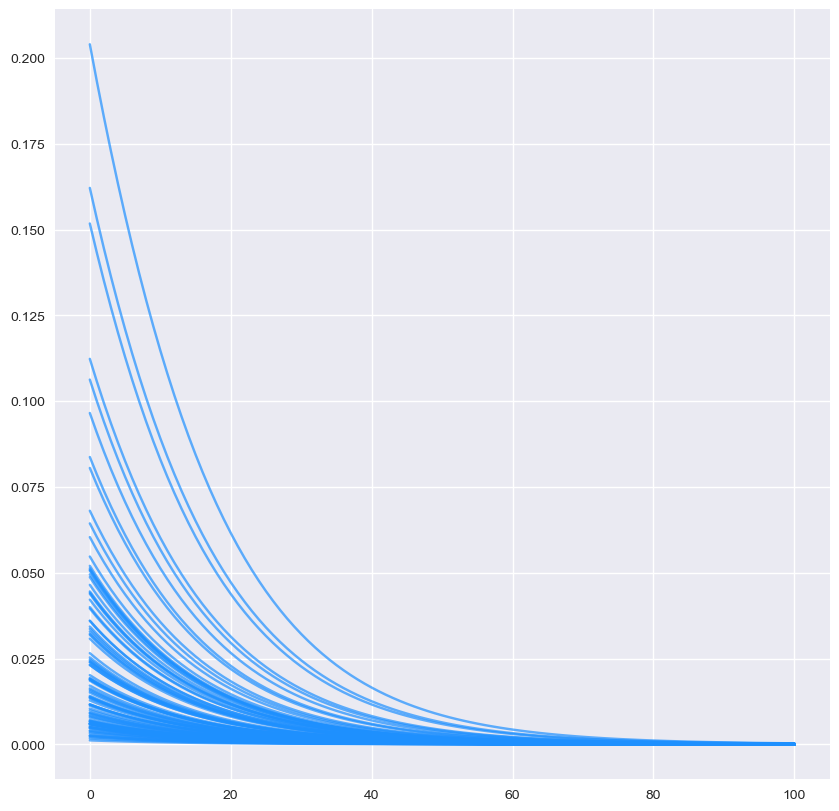

In [55]:
#AIF1の変化
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for cell_number in range(0,100):
    ax.plot(gene_matrix.columns,gene_matrix.loc[cell_number],color = 'dodgerblue',alpha = 0.7)
                
fig.show()

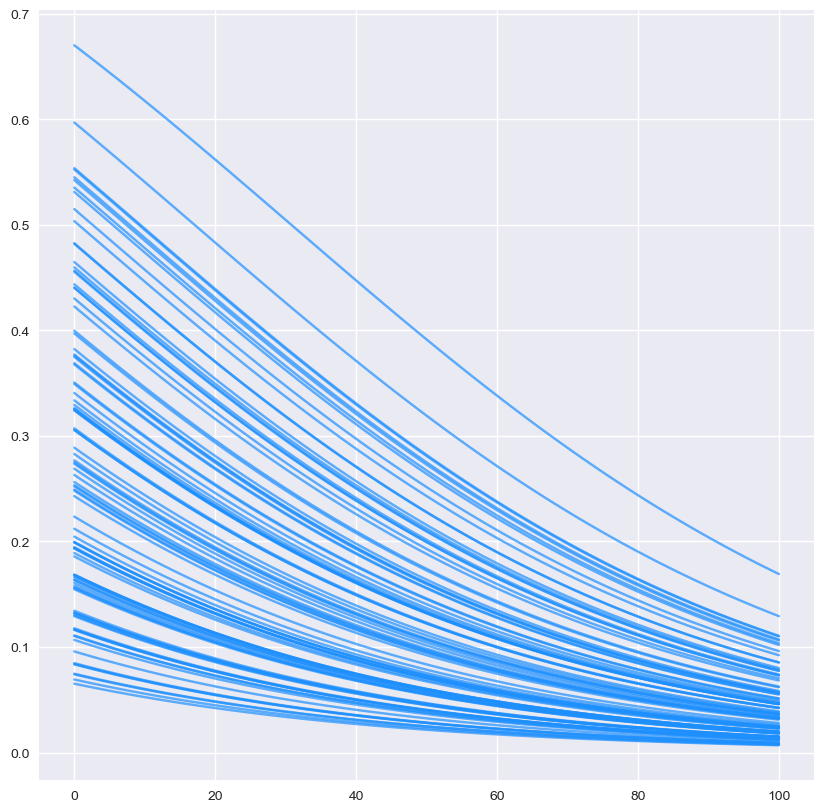

In [122]:
#他の老化関連して変化する遺伝子でも試してみる
#MIR14は老化に伴って390.2%増加する遺伝子
gene_matrix = pd.DataFrame()

for age in range(0,101,1):
    gene_matrix = pd.concat([gene_matrix,simulation_list[age]["ANXA4"]],axis=1)
    
gene_matrix.columns = [i for i in range(0,101,1)]

plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for cell_number in range(0,100):
    ax.plot(gene_matrix.columns,gene_matrix.loc[cell_number],color = 'dodgerblue',alpha = 0.7)
                
plt.show()

In [57]:

pd.DataFrame(gene_matrix.mean()).T

0        1         2         3         4         5         6    \
0  0.673036  0.67531  0.677577  0.679836  0.682086  0.684327  0.686561   

        7         8         9      ...          91        92        93   \
0  0.688786  0.691003  0.693211    ...     0.841295  0.842684  0.844063   

        94        95        96        97        98        99        100  
0  0.845432  0.846792  0.848142  0.849482  0.850813  0.852134  0.853445  

[1 rows x 101 columns]

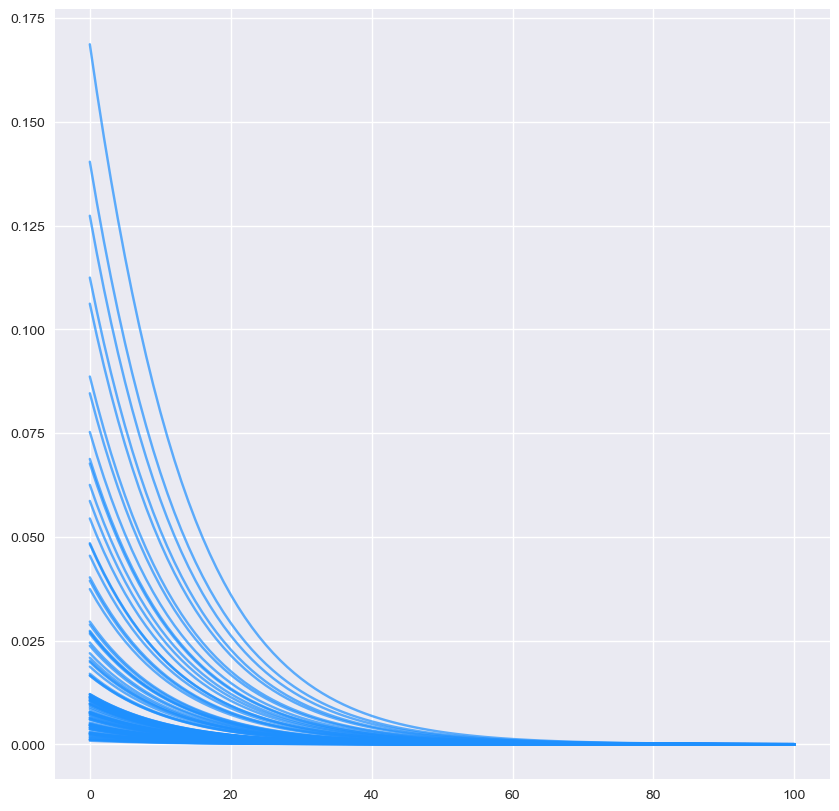

In [182]:
gene_matrix = pd.DataFrame()

for age in range(0,101,1):
    gene_matrix = pd.concat([gene_matrix,simulation_list[age]["CASP1"]],axis=1)
    
gene_matrix.columns = [i for i in range(0,101,1)]

plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for cell_number in range(0,100):
    ax.plot(gene_matrix.columns,gene_matrix.loc[cell_number],color = 'dodgerblue',alpha = 0.7)
                
plt.show()

In [ ]:
'''#全ての遺伝子の変動をシミュレーションする
#その後それらをクラスタリングする

#all_gene_matrixにはインデックスの遺伝子の並び順で100この細胞の遺伝子発現シミュレーションが並んでいる
all_gene_matrix = pd.DataFrame()

for gene_name in rnaseq_df.index:
    gene_matrix = pd.DataFrame()
    i = 1
    for age in simulation_list:
        gene_matrix = pd.concat([gene_matrix,simulation_list[age][gene_name]],axis=1)
        i += 1
        if i == len(simulation_list):
            gene_matrix.columns = [i for i in range(0,len(simulation_list)+1)]
            all_gene_matrix = pd.concat([all_gene_matrix,gene_matrix],axis = 1)
'''    


In [59]:
#全ての遺伝子の変動をシミュレーションする
#その後それらをクラスタリングする

#all_gene_matrixにはインデックスの遺伝子の並び順で100この細胞の遺伝子発現シミュレーションが並んでいる
all_gene_matrix = pd.DataFrame()

for gene_name in rnaseq_df.columns:
    gene_matrix = pd.DataFrame()
    j = 1
    for i,age in enumerate(simulation_list):
        gene_matrix = pd.concat([gene_matrix,simulation_list[i][gene_name]],axis=1)
        j += 1
        if j == len(simulation_list) +1:
            #gene_matrix.index = [i for i in range(0,len(simulation_list)+1)]
            gene_matrix_mean=pd.DataFrame(gene_matrix.mean()).T
            gene_matrix_mean.columns = [k for k in range(0,101)]
            all_gene_matrix = pd.concat([all_gene_matrix,gene_matrix_mean],axis = 0)

all_gene_matrix.index = rnaseq_df.columns
all_gene_matrix.columns = gene_matrix_mean.columns

In [60]:
all_gene_matrix

0         1         2         3         4         5    \
1/2-SBSRNA4  0.049648  0.046502  0.043542  0.040757  0.038138  0.035677   
A1BG         0.150686  0.147529  0.144424  0.141372  0.138371  0.135421   
A1BG-AS1     0.050541  0.047216  0.044092  0.041157  0.038403  0.035820   
A1CF         0.212684  0.208234  0.203849  0.199531  0.195279  0.191093   
A2LD1        0.067323  0.063145  0.059201  0.055480  0.051972  0.048668   
A2M          0.039089  0.037546  0.036056  0.034619  0.033231  0.031893   
A2ML1        0.015945  0.014765  0.013668  0.012650  0.011705  0.010828   
A2MP1        0.005056  0.004550  0.004093  0.003681  0.003310  0.002976   
A4GALT       0.033047  0.030889  0.028862  0.026959  0.025174  0.023500   
A4GNT        0.010403  0.009696  0.009035  0.008418  0.007842  0.007304   
AA06         0.004096  0.003704  0.003349  0.003027  0.002736  0.002473   
AAA1         0.070638  0.067354  0.064204  0.061186  0.058294  0.055525   
AAAS         0.159863  0.154963  0.150182  0.145519  0.140973  0.136542   
AACS         0.215501  0.210893  0.206355  0.201888  0.197491  0.193165   
AACSP1       0.009399  0.008451  0.007596  0.006826  0.006133  0.005509   
AADAC        0.063122  0.059455  0.055980  0.052690  0.049577  0.046632   
AADACL2      0.004459  0.004044  0.003667  0.003325  0.003014  0.002732   
AADACL3      0.004620  0.004127  0.003685  0.003290  0.002937  0.002621   
AADACL4      0.005502  0.004936  0.004427  0.003970  0.003560  0.003192   
AADAT        0.068497  0.065127  0.061906  0.058830  0.055893  0.053091   
AAGAB        0.251163  0.243913  0.236802  0.229830  0.223000  0.216311   
AAK1         0.300006  0.296419  0.292858  0.289321  0.285809  0.282322   
AAMP         0.222270  0.218511  0.214795  0.211124  0.207498  0.203917   
AANAT        0.014655  0.013381  0.012213  0.011145  0.010167  0.009273   
AARS         0.213229  0.209057  0.204944  0.200890  0.196894  0.192956   
AARS2        0.112924  0.107200  0.101722  0.096485  0.091482  0.086706   
AARSD1       0.192915  0.188997  0.185140  0.181342  0.177603  0.173924   
AASDH        0.154245  0.149641  0.145146  0.140761  0.136482  0.132310   
AASDHPPT     0.285250  0.279943  0.274696  0.269509  0.264384  0.259320   
AASS         0.104127  0.100307  0.096606  0.093021  0.089551  0.086192   
...               ...       ...       ...       ...       ...       ...   
ZSCAN2       0.123665  0.118456  0.113432  0.108588  0.103920  0.099426   
ZSCAN20      0.039255  0.036587  0.034090  0.031753  0.029569  0.027527   
ZSCAN21      0.105463  0.101035  0.096768  0.092658  0.088702  0.084894   
ZSCAN22      0.099386  0.094533  0.089884  0.085434  0.081177  0.077106   
ZSCAN23      0.060182  0.056164  0.052389  0.048844  0.045519  0.042403   
ZSCAN29      0.118053  0.112204  0.106600  0.101235  0.096103  0.091198   
ZSCAN30      0.138885  0.134198  0.129640  0.125211  0.120908  0.116729   
ZSCAN4       0.015992  0.014362  0.012891  0.011565  0.010370  0.009295   
ZSCAN5A      0.079495  0.074548  0.069875  0.065464  0.061304  0.057385   
ZSCAN5B      0.014153  0.012840  0.011643  0.010553  0.009562  0.008661   
ZSWIM1       0.101407  0.096664  0.092113  0.087751  0.083570  0.079566   
ZSWIM2       0.016137  0.014637  0.013271  0.012028  0.010897  0.009869   
ZSWIM3       0.037002  0.034310  0.031797  0.029455  0.027272  0.025240   
ZSWIM4       0.099287  0.094149  0.089238  0.084549  0.080074  0.075806   
ZSWIM5       0.105989  0.100496  0.095248  0.090237  0.085456  0.080898   
ZSWIM6       0.101347  0.098264  0.095263  0.092340  0.089496  0.086728   
ZSWIM7       0.220803  0.215143  0.209586  0.204133  0.198783  0.193536   
ZUFSP        0.190229  0.183956  0.177840  0.171880  0.166074  0.160423   
ZW10         0.130705  0.124280  0.118120  0.112218  0.106568  0.101163   
ZWILCH       0.094111  0.088843  0.083834  0.079073  0.074552  0.070263   
ZWINT        0.061113  0.057233  0.053576  0.050132  0.046890  0.043841   
ZXDA         0.120127  0.114281  0.108676  

In [61]:
#全ての遺伝子の変動の様子をk-meansでクラスタリングする
from sklearn.cluster import KMeans
#とりあえず4つのクラスターに分類
kmeans_model = KMeans(n_clusters=4, random_state=10).fit(all_gene_matrix)
labels = kmeans_model.labels_

cluster_number = pd.DataFrame(labels)
cluster_number.index = rnaseq_df.columns
cluster_number = cluster_number.astype(str)
cluster_number.columns = ["cluster_number"]
print(cluster_number)


            cluster_number
1/2-SBSRNA4              0
A1BG                     2
A1BG-AS1                 0
A1CF                     2
A2LD1                    0
A2M                      0
A2ML1                    0
A2MP1                    0
A4GALT                   0
A4GNT                    0
AA06                     0
AAA1                     0
AAAS                     2
AACS                     2
AACSP1                   0
AADAC                    0
AADACL2                  0
AADACL3                  0
AADACL4                  0
AADAT                    0
AAGAB                    2
AAK1                     1
AAMP                     2
AANAT                    0
AARS                     2
AARS2                    0
AARSD1                   2
AASDH                    2
AASDHPPT                 2
AASS                     0
...                    ...
ZSCAN2                   0
ZSCAN20                  0
ZSCAN21                  0
ZSCAN22                  0
ZSCAN23                  0
Z

In [62]:
#kmeansの結果を可視化

#クラスター番号ごとに抽出
cluster_0 = cluster_number[cluster_number["cluster_number"].str.match("0")]
cluster_1= cluster_number[cluster_number["cluster_number"].str.match("1")]
cluster_2= cluster_number[cluster_number["cluster_number"].str.match("2")]
cluster_3= cluster_number[cluster_number["cluster_number"].str.match("3")]

In [117]:
cluster_3

cluster_number
ACADVL                3
ACTB                  3
ACTG1                 3
AKAP9                 3
ALDH1A1               3
ALDOA                 3
ANXA2                 3
ANXA5                 3
ANXA7                 3
APLP2                 3
ARF1                  3
ARF4                  3
ARPC2                 3
ARPC3                 3
ATP1B1                3
ATP5A1                3
ATP5B                 3
ATP5C1                3
ATP5E                 3
ATP5F1                3
ATP5G2                3
ATP5G3                3
ATP5J                 3
ATP5L                 3
ATP5O                 3
ATP6V0B               3
ATP6V0E1              3
ATP6V1G1              3
ATPIF1                3
B2M                   3
...                 ...
TMSB4X                3
TPI1                  3
TPM3                  3
TPT1                  3
TSC22D1               3
TSPAN3                3
TTC3                  3
TTR                   3
TUBA1A                3
TUBA1B                3
TXN                   3
UBA52                 3
UBB                   3
UBC                   3
UBE2D3                3
UBL5                  3
UBXN4                 3
UQCR11                3
UQCRB                 3
UQCRQ                 3
VAPA                  3
XBP1                  3
XRCC6                 3
YPEL5                 3
YWHAB                 3
YWHAE                 3
YWHAQ                 3
YWHAZ                 3
ZFAND5                3
ZFP36                 3

[418 rows x 1 columns]

In [64]:
cluster_0_gene = all_gene_matrix.loc[cluster_0.index].T
cluster_1_gene = all_gene_matrix.loc[cluster_1.index].T
cluster_2_gene = all_gene_matrix.loc[cluster_2.index].T
cluster_3_gene = all_gene_matrix.loc[cluster_3.index].T

In [119]:
'''#クラスター0を可視化
cluster_0_gene = all_gene_matrix.loc[cluster_0.index].T

plt.style.use('default')
sns.set()

cluster_0_gene.plot(color = 'dodgerblue',alpha = 0.7)
plt.savefig("/Users/yokosaka/Desktop/python/cluster_0_image.png")
plt.show()
'''

ValueError: Image size of 572x325024 pixels is too large. It must be less than 2^16 in each direction.

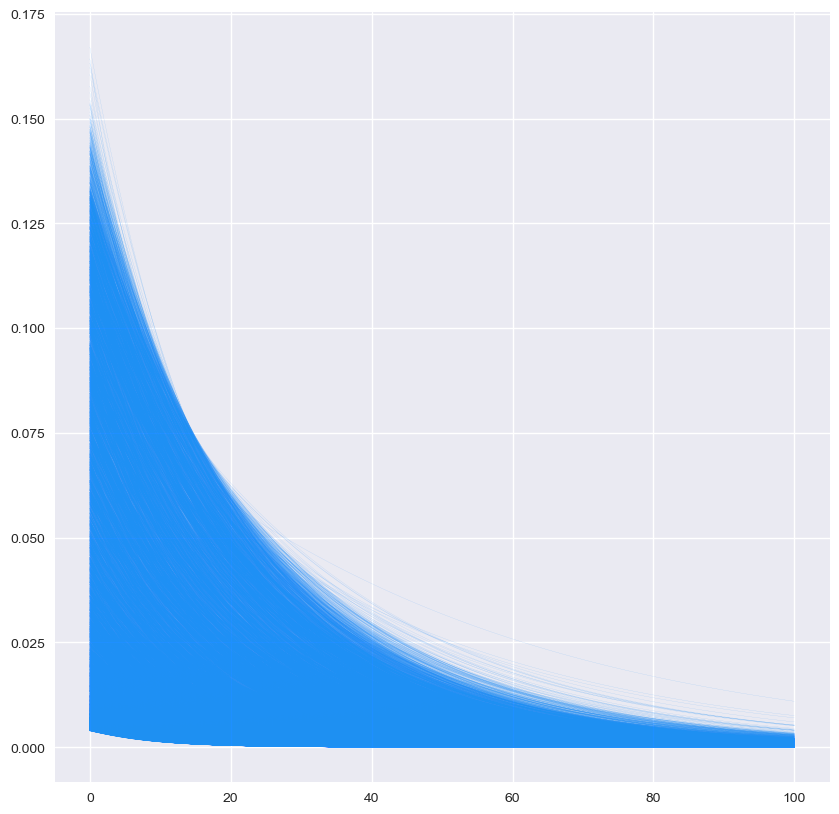

In [65]:
#クラスター0を可視化 別の方法で
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_0_gene.columns:
    ax.plot(cluster_0_gene.index,cluster_0_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.1)
                
plt.show()

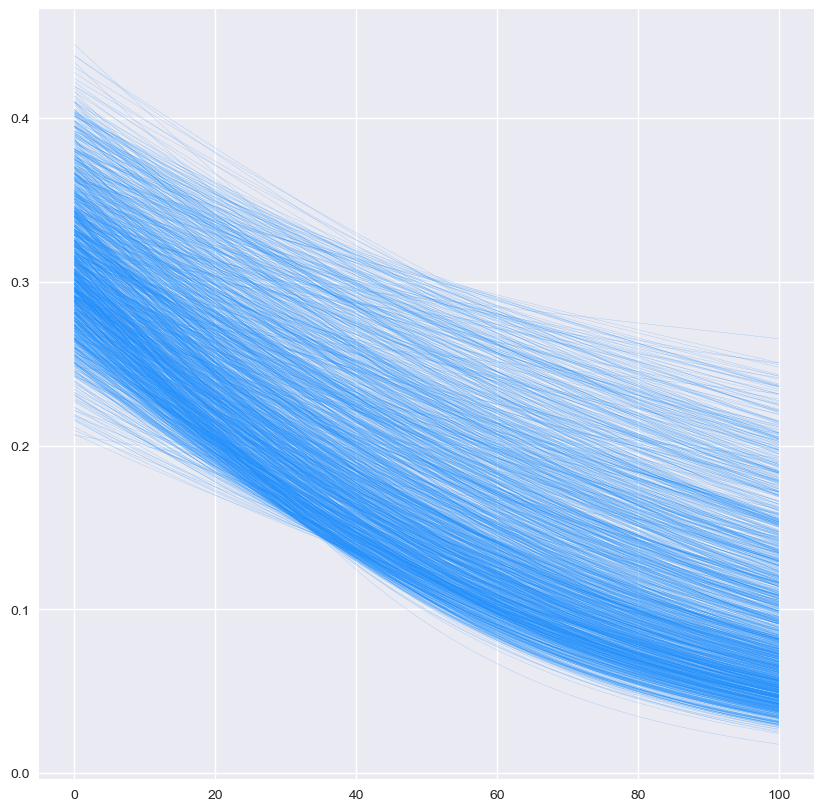

In [66]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_1_gene.columns:
    ax.plot(cluster_1_gene.index,cluster_1_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.2)
                
plt.show()

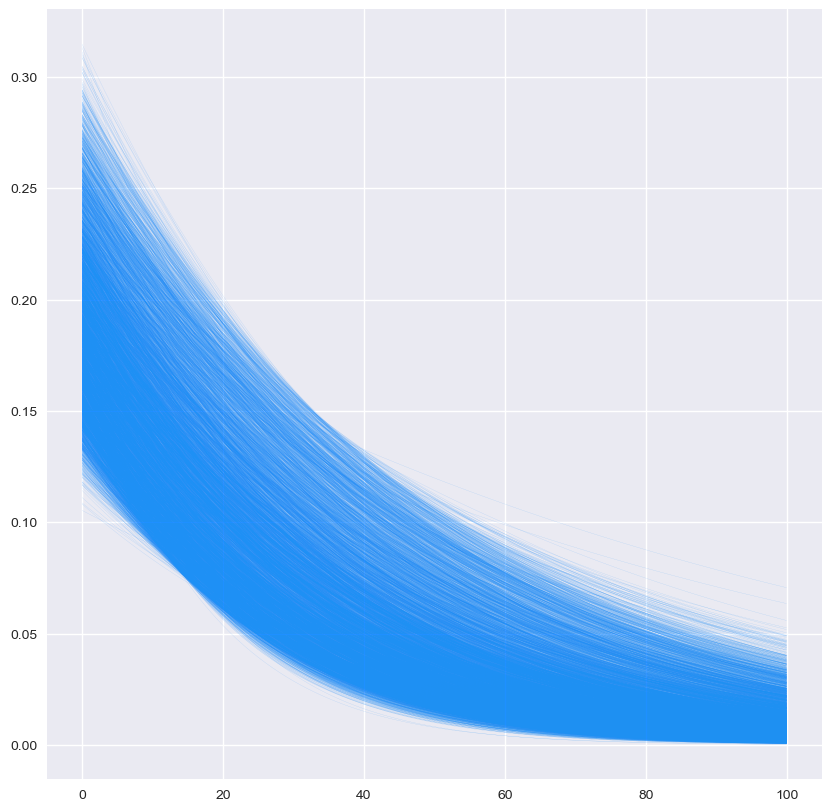

In [67]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_2_gene.columns:
    ax.plot(cluster_2_gene.index,cluster_2_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.1)
                
plt.show()

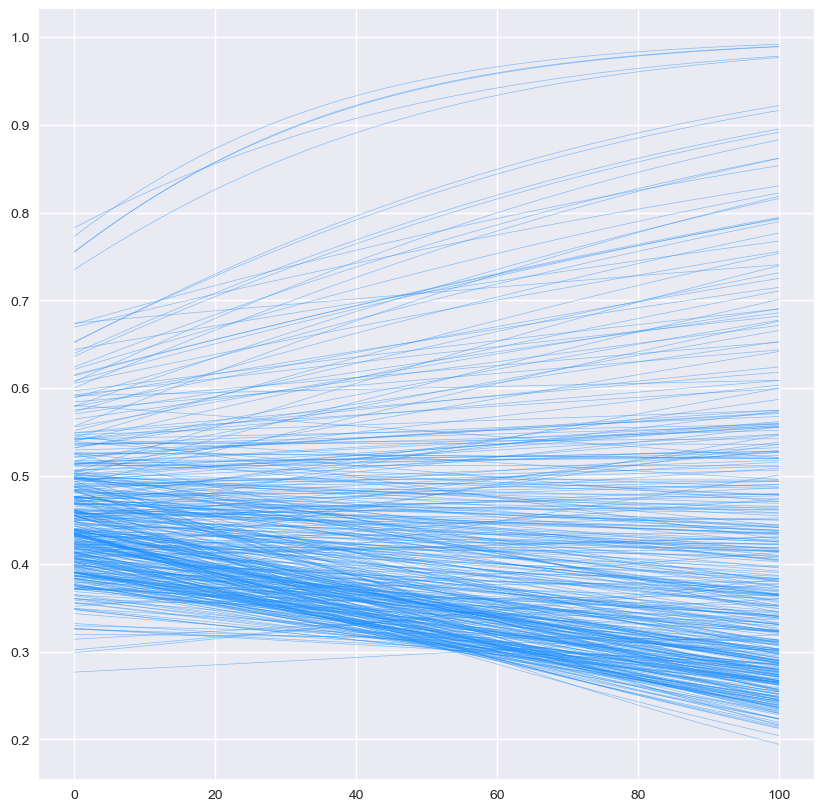

In [68]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_3_gene.columns:
    ax.plot(cluster_3_gene.index,cluster_3_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.5)
                
plt.show()

In [69]:
#tslearnを使った時系列クラスタリング
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax

In [70]:

from tslearn.generators import random_walks
X = random_walks(n_ts=5, sz=3, d=1)
print(X)
print(X.shape)

[[[ 2.08150156]
  [ 0.20277137]
  [-0.95406863]]

 [[ 0.32948909]
  [-0.74335119]
  [-0.6644568 ]]

 [[ 1.07533661]
  [ 2.85195944]
  [ 4.2633764 ]]

 [[-0.02926718]
  [ 0.68266873]
  [ 0.87235792]]

 [[ 0.28945889]
  [-0.47413085]
  [-0.20761019]]]
(5, 3, 1)


In [71]:
timeseries_kmean_input = []
for gene_name in all_gene_matrix.index:
    vector = np.array(all_gene_matrix.loc[gene_name])
    timeseries_kmean_input.append(vector)
    
timeseries_kmean_input_data = np.stack(timeseries_kmean_input,axis=0)
timeseries_kmean_input_data

array([[  4.96476330e-02,   4.65023965e-02,   4.35417742e-02, ...,
          5.08022385e-05,   4.73123691e-05,   4.40622134e-05],
       [  1.50685847e-01,   1.47528782e-01,   1.44424245e-01, ...,
          1.40724555e-02,   1.37122348e-02,   1.33610293e-02],
       [  5.05412593e-02,   4.72163968e-02,   4.40916345e-02, ...,
          3.43760694e-05,   3.18716047e-05,   2.95496066e-05],
       ..., 
       [  2.05673352e-01,   2.00337112e-01,   1.95102572e-01, ...,
          9.53260530e-03,   9.21764411e-03,   8.91298149e-03],
       [  2.49665216e-01,   2.43674323e-01,   2.37779409e-01, ...,
          1.32726431e-02,   1.28468713e-02,   1.24345599e-02],
       [  1.28918765e-02,   1.18814064e-02,   1.09472005e-02, ...,
          3.18412413e-06,   2.92398886e-06,   2.68510394e-06]], dtype=float32)

In [88]:
#スパコンに送るファイルを作る
np.savetxt("timeseries_kmean_input_data.csv",X=timeseries_kmean_input_data,delimiter=",")

In [90]:
data = np.loadtxt("/Users/yokosaka/Desktop/python/timeseries_kmean_input_data.csv",       # 読み込みたいファイルのパス
                  delimiter=",",    # ファイルの区切り文字
                  skiprows=0,       # 先頭の何行を無視するか（指定した行数までは読み込まない）
                   # 読み込みたい列番号
                 )

In [93]:
timeseries_kmean_input_data.shape

(23460, 101, 1)

In [94]:
data.shape

(23460, 101)

In [97]:
timeseries_kmean_input_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(timeseries_kmean_input_data)

In [98]:
tkm = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=50, verbose=False, random_state=0)

In [99]:
tkm.fit(timeseries_kmean_input_data)

KeyboardInterrupt: 

In [ ]:
tkm_labels = tkm.labels_
tkm_labels

In [ ]:
tkm_labels_df = pd.DataFrame(tkm_labels, index = rnaseq_df.columns , columns = ["cluster"])

In [ ]:
tkm_labels_df = tkm_labels_df.astype(str)

In [ ]:
cluster_0_DTW = tkm_labels_df[tkm_labels_df["cluster"].str.match("0")]
cluster_1_DTW= tkm_labels_df[tkm_labels_df["cluster"].str.match("1")]
cluster_2_DTW= tkm_labels_df[tkm_labels_df["cluster"].str.match("2")]
cluster_3_DTW= tkm_labels_df[tkm_labels_df["cluster"].str.match("3")]

In [166]:
cluster_0_DTW

cluster
A1BG            0
A1CF            0
AAAS            0
AACS            0
AAGAB           0
AAK1            0
AAMP            0
AARS            0
AARSD1          0
AASDH           0
AASDHPPT        0
AASS            0
AATF            0
ABAT            0
ABCA1           0
ABCA11P         0
ABCA2           0
ABCA3           0
ABCA5           0
ABCA7           0
ABCB1           0
ABCB10          0
ABCB6           0
ABCB7           0
ABCB8           0
ABCC1           0
ABCC10          0
ABCC3           0
ABCC4           0
ABCC5           0
...           ...
ZNHIT2          0
ZNHIT3          0
ZNHIT6          0
ZNRD1           0
ZNRF1           0
ZNRF2           0
ZNRF3           0
ZRANB1          0
ZRANB2          0
ZRSR2           0
ZSCAN1          0
ZSCAN12         0
ZSCAN12P1       0
ZSCAN16         0
ZSCAN18         0
ZSCAN2          0
ZSCAN21         0
ZSCAN22         0
ZSCAN30         0
ZSWIM1          0
ZSWIM6          0
ZSWIM7          0
ZUFSP           0
ZXDA            0
ZXDB            0
ZXDC            0
ZYG11B          0
ZYX             0
ZZEF1           0
ZZZ3            0

[9947 rows x 1 columns]

In [ ]:
cluster_0_DTW_gene = all_gene_matrix.loc[cluster_0_DTW.index].T
cluster_1_DTW_gene = all_gene_matrix.loc[cluster_1_DTW.index].T
cluster_2_DTW_gene = all_gene_matrix.loc[cluster_2_DTW.index].T
cluster_3_DTW_gene = all_gene_matrix.loc[cluster_3_DTW.index].T

In [ ]:
cluster_0_DTW_gene

In [ ]:
#DTWをメトリックスとしたkmeansクラスタリング
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_0_DTW_gene.columns:
    ax.plot(cluster_0_DTW_gene.index,cluster_0_DTW_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.3)
                
plt.show()

In [ ]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_1_DTW_gene.columns:
    ax.plot(cluster_1_DTW_gene.index,cluster_1_DTW_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.3)
                
plt.show()

In [ ]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_2_DTW_gene.columns:
    ax.plot(cluster_2_DTW_gene.index,cluster_2_DTW_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=0.5)
                
plt.show()

In [ ]:
#クラスターC
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

for gene_name in cluster_3_DTW_gene.columns:
    ax.plot(cluster_3_DTW_gene.index,cluster_3_DTW_gene[gene_name],color = 'dodgerblue',alpha = 0.5,lw=1)
                
plt.show()

In [4]:
#入力RNA-seqデータのt-SNE分布と生成RNA-seqデータのt-SNE分布の類似度を可視化して生成の正確さを確かめる
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,learning_rate=300, n_iter=400)
tsne_out_real = tsne.fit_transform(rnaseq_df)
tsne_out_real = pd.DataFrame(tsne_out_real, columns=['1', '2'])
tsne_out_real.index = rnaseq_df.index


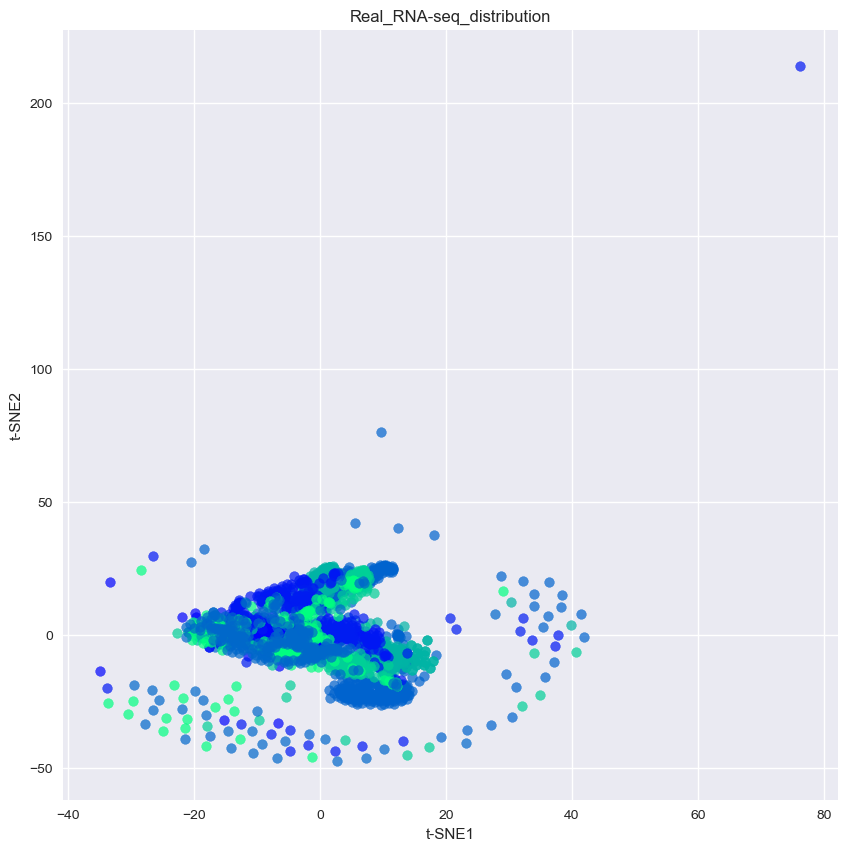

In [74]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('Real_RNA-seq_distribution')
ax = fig.add_subplot(1,1,1)
    
ax.scatter(tsne_out_real.iloc[0:505,0], tsne_out_real.iloc[0:505, 1],c = plt.cm.winter(21/54),label = "21year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[505:979,0], tsne_out_real.iloc[505:979, 1],c = plt.cm.winter(38/54),label = "38year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[979:1200,0],tsne_out_real.iloc[979:1200, 1],c = plt.cm.winter(1/54),label = "01year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[1200:1531,0],tsne_out_real.iloc[1200:1531, 1],c = plt.cm.winter(5/54),label = "05year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[1531:1808,0], tsne_out_real.iloc[1531:1808, 1],c = plt.cm.winter(44/54),label = "44year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[1808:1986,0],tsne_out_real.iloc[1808:1986, 1],c = plt.cm.winter(6/54),label = "06year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[1986:2258,0], tsne_out_real.iloc[1986:2258, 1],c = plt.cm.winter(54/54),label = "54year",alpha=0.7)
ax.scatter(tsne_out_real.iloc[2258:len(tsne_out_real),0], tsne_out_real.iloc[2258:len(tsne_out_real), 1],c = plt.cm.winter(22/54),label = "22year",alpha=0.7)
#青から緑色になる程年齢が高くなっていく
#ax.collections[0].colorbar.minorticks_on()

plt.xlim([-50,50])
plt.ylim([-50,50])


ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')


plt.show()

In [75]:
#生成データのt-SNE分布を可視化
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,learning_rate=300, n_iter=400)
tsne_out_generated = tsne.fit_transform(decoder.predict(pd.concat([encoded_rnaseq_df_1,age_label],axis = 1)))
tsne_out_generated = pd.DataFrame(tsne_out_generated, columns=['1', '2'])
tsne_out_generated.index = rnaseq_df.index

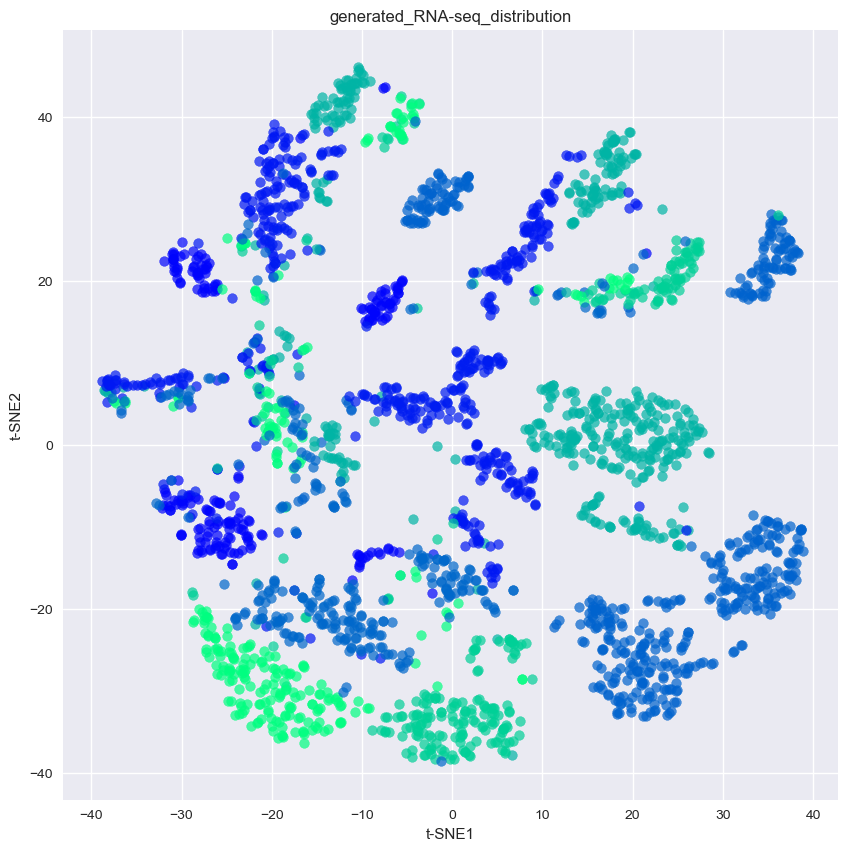

In [76]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('generated_RNA-seq_distribution')
ax = fig.add_subplot(1,1,1)
    
ax.scatter(tsne_out_generated.iloc[0:505,0], tsne_out_generated.iloc[0:505, 1],c = plt.cm.winter(21/54),label = "21year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[505:979,0], tsne_out_generated.iloc[505:979, 1],c = plt.cm.winter(38/54),label = "38year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[979:1200,0],tsne_out_generated.iloc[979:1200, 1],c = plt.cm.winter(1/54),label = "01year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[1200:1531,0],tsne_out_generated.iloc[1200:1531, 1],c = plt.cm.winter(5/54),label = "05year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[1531:1808,0], tsne_out_generated.iloc[1531:1808, 1],c = plt.cm.winter(44/54),label = "44year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[1808:1986,0],tsne_out_generated.iloc[1808:1986, 1],c = plt.cm.winter(6/54),label = "06year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[1986:2258,0], tsne_out_generated.iloc[1986:2258, 1],c = plt.cm.winter(54/54),label = "54year",alpha=0.7)
ax.scatter(tsne_out_generated.iloc[2258:len(tsne_out_generated),0], tsne_out_generated.iloc[2258:len(tsne_out_generated), 1],c = plt.cm.winter(22/54),label = "22year",alpha=0.7)
#青から緑色になる程年齢が高くなっていく
#ax.collections[0].colorbar.minorticks_on()

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')


plt.show()

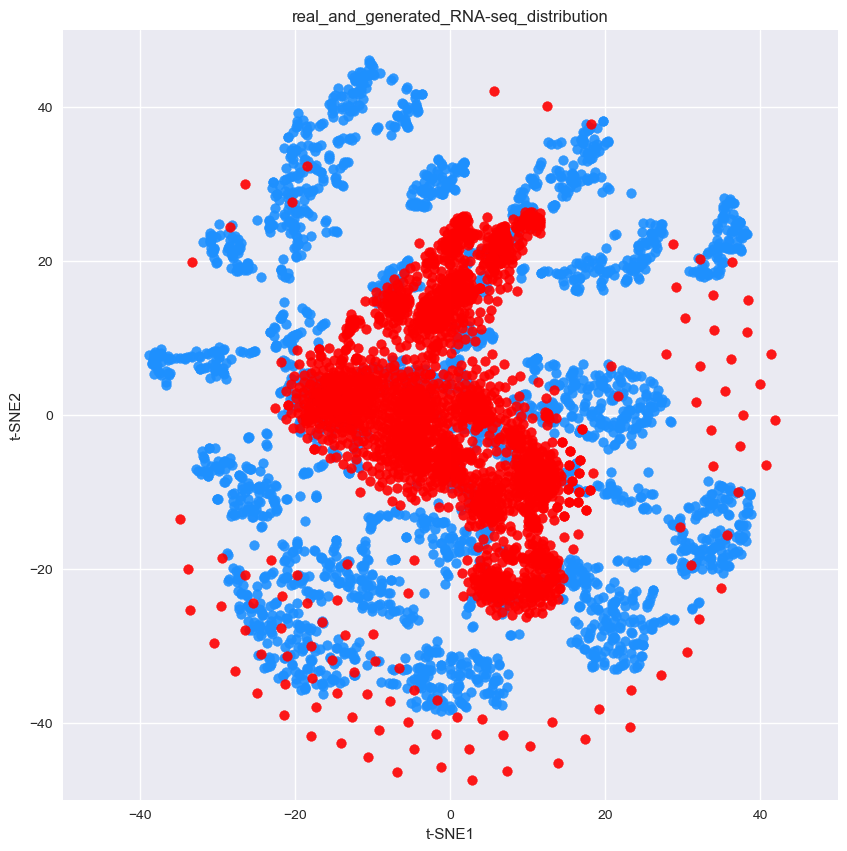

In [87]:
#上の二つを重ねる
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('real_and_generated_RNA-seq_distribution')
ax = fig.add_subplot(1,1,1)

ax.scatter(tsne_out_real["1"],tsne_out_real["2"],c = "red",alpha = 0.9)
ax.scatter(tsne_out_generated["1"],tsne_out_generated["2"],c ="dodgerblue",alpha = 0.9)

plt.xlim([-50,50])
plt.ylim([-50,50])

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')

plt.show()

In [131]:
age_label

age_label
GSM2171880_21       21.0
GSM2171881_21       21.0
GSM2171882_21       21.0
GSM2171883_21       21.0
GSM2171884_21       21.0
GSM2171885_21       21.0
GSM2171886_21       21.0
GSM2171887_21       21.0
GSM2171888_21       21.0
GSM2171889_21       21.0
GSM2171890_21       21.0
GSM2171891_21       21.0
GSM2171892_21       21.0
GSM2171893_21       21.0
GSM2171894_21       21.0
GSM2171895_21       21.0
GSM2171896_21       21.0
GSM2171897_21       21.0
GSM2171898_21       21.0
GSM2171899_21       21.0
GSM2171900_21       21.0
GSM2171901_21       21.0
GSM2171902_21       21.0
GSM2171903_21       21.0
GSM2171904_21       21.0
GSM2171905_21       21.0
GSM2171906_21       21.0
GSM2171907_21       21.0
GSM2171908_21       21.0
GSM2171909_21       21.0
...                  ...
GSM2174396_22       22.0
GSM2174397_22       22.0
GSM2174398_22       22.0
GSM2174399_22       22.0
GSM2174400_22       22.0
GSM2174401_22       22.0
GSM2174402_22       22.0
GSM2174403_22       22.0
GSM2174404_22       22.0
GSM2174405_22       22.0
GSM2174406_22       22.0
GSM2174407_22       22.0
GSM2174408_22       22.0
GSM2174409_22       22.0
GSM2174410_22       22.0
GSM2174411_22       22.0
GSM2174412_22       22.0
GSM2174413_22       22.0
GSM2174414_22       22.0
GSM2174415_22       22.0
GSM2174416_22       22.0
GSM2174417_22       22.0
GSM2174418_22       22.0
GSM2174419_22       22.0
GSM2174420_22       22.0
GSM2174421_22       22.0
GSM2174422_22       22.0
GSM2174423_22       22.0
GSM2174424_22       22.0
GSM2174425_22       22.0

[2544 rows x 1 columns]

In [6]:
#潜在変数のプロットを細胞型で色分けしてみる
cell_type = pd.read_table("/Users/yokosaka/Desktop/python/GSE81547_cell_type.txt",index_col = 0)

In [126]:
cell_type

cell_type
GSM2171880_21        alpha
GSM2171881_21        alpha
GSM2171882_21       acinar
GSM2171883_21        alpha
GSM2171884_21        alpha
GSM2171885_21        alpha
GSM2171886_21       unsure
GSM2171887_21       unsure
GSM2171888_21       acinar
GSM2171889_21       acinar
GSM2171890_21       acinar
GSM2171891_21       acinar
GSM2171892_21       unsure
GSM2171893_21       acinar
GSM2171894_21       acinar
GSM2171895_21        alpha
GSM2171896_21       acinar
GSM2171897_21       acinar
GSM2171898_21       acinar
GSM2171899_21       acinar
GSM2171900_21       acinar
GSM2171901_21       acinar
GSM2171902_21       unsure
GSM2171903_21       unsure
GSM2171904_21       unsure
GSM2171905_21       acinar
GSM2171906_21        alpha
GSM2171907_21        alpha
GSM2171908_21       unsure
GSM2171909_21       acinar
...                    ...
GSM2174396_22        alpha
GSM2174397_22        alpha
GSM2174398_22        alpha
GSM2174399_22        alpha
GSM2174400_22        alpha
GSM2174401_22        delta
GSM2174402_22       unsure
GSM2174403_22         beta
GSM2174404_22        alpha
GSM2174405_22       unsure
GSM2174406_22         beta
GSM2174407_22         beta
GSM2174408_22         beta
GSM2174409_22        alpha
GSM2174410_22       ductal
GSM2174411_22        alpha
GSM2174412_22        alpha
GSM2174413_22        alpha
GSM2174414_22       unsure
GSM2174415_22       unsure
GSM2174416_22         beta
GSM2174417_22         beta
GSM2174418_22        alpha
GSM2174419_22        alpha
GSM2174420_22        alpha
GSM2174421_22       unsure
GSM2174422_22         beta
GSM2174423_22  mesenchymal
GSM2174424_22        alpha
GSM2174425_22        alpha

[2544 rows x 1 columns]

In [128]:
#いくつの細胞型があるか
cell_type["cell_type"].unique()

array(['alpha', 'acinar', 'unsure', 'delta', 'beta', 'ductal',
       'mesenchymal'], dtype=object)

In [139]:
#それぞれのドナー(=年齢)について細胞型の割合を算出

#それぞれのドナーごとに細胞型の頻度を計算する
print(len(cell_type.iloc[0:505,0]))
cell_type_freq_21 = cell_type.iloc[0:505,0].value_counts()
cell_type_freq_21 =  cell_type_freq_21.apply(lambda x :x/len(cell_type.iloc[0:505,0]))

cell_type_freq_38 = cell_type.iloc[505:979,0].value_counts()
cell_type_freq_38 =  cell_type_freq_38.apply(lambda x :x/len(cell_type.iloc[505:979,0]))

cell_type_freq_01 = cell_type.iloc[979:1200,0].value_counts()
cell_type_freq_01 =  cell_type_freq_01.apply(lambda x :x/len(cell_type.iloc[979:1200,0]))

cell_type_freq_05 = cell_type.iloc[1200:1531,0].value_counts()
cell_type_freq_05 =  cell_type_freq_05.apply(lambda x :x/len(cell_type.iloc[1200:1531,0]))

cell_type_freq_44 = cell_type.iloc[1531:1808,0].value_counts()
cell_type_freq_44 =  cell_type_freq_44.apply(lambda x :x/len(cell_type.iloc[1531:1808,0]))

cell_type_freq_06= cell_type.iloc[1808:1986,0].value_counts()
cell_type_freq_06 =  cell_type_freq_06.apply(lambda x :x/len(cell_type.iloc[1808:1986,0]))

cell_type_freq_54= cell_type.iloc[1986:2258,0].value_counts()
cell_type_freq_54 =  cell_type_freq_54.apply(lambda x :x/len(cell_type.iloc[1986:2258,0]))

cell_type_freq_22= cell_type.iloc[2258:len(cell_type),0].value_counts()
cell_type_freq_22 =  cell_type_freq_22.apply(lambda x :x/len(cell_type.iloc[2258:len(cell_type),0]))

505


In [140]:
print(cell_type_freq_21,cell_type_freq_38,cell_type_freq_01,cell_type_freq_05,cell_type_freq_44,cell_type_freq_06,cell_type_freq_54,cell_type_freq_22)

unsure    0.330693
alpha     0.310891
ductal    0.176238
acinar    0.146535
delta     0.027723
beta      0.007921
Name: cell_type, dtype: float64 alpha          0.445148
ductal         0.181435
beta           0.179325
acinar         0.132911
delta          0.031646
unsure         0.016878
mesenchymal    0.012658
Name: cell_type, dtype: float64 alpha          0.398190
acinar         0.303167
beta           0.099548
ductal         0.085973
mesenchymal    0.058824
delta          0.031674
unsure         0.022624
Name: cell_type, dtype: float64 alpha          0.416918
ductal         0.178248
beta           0.160121
acinar         0.129909
unsure         0.090634
delta          0.021148
mesenchymal    0.003021
Name: cell_type, dtype: float64 alpha          0.281588
ductal         0.270758
acinar         0.209386
beta           0.129964
mesenchymal    0.068592
unsure         0.021661
delta          0.018051
Name: cell_type, dtype: float64 acinar         0.337079
ductal         0.258427
beta  

In [145]:
type(cell_type_freq_21)

pandas.core.series.Series

Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')
Index(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'mesenchymal', 'unsure'], dtype='object')


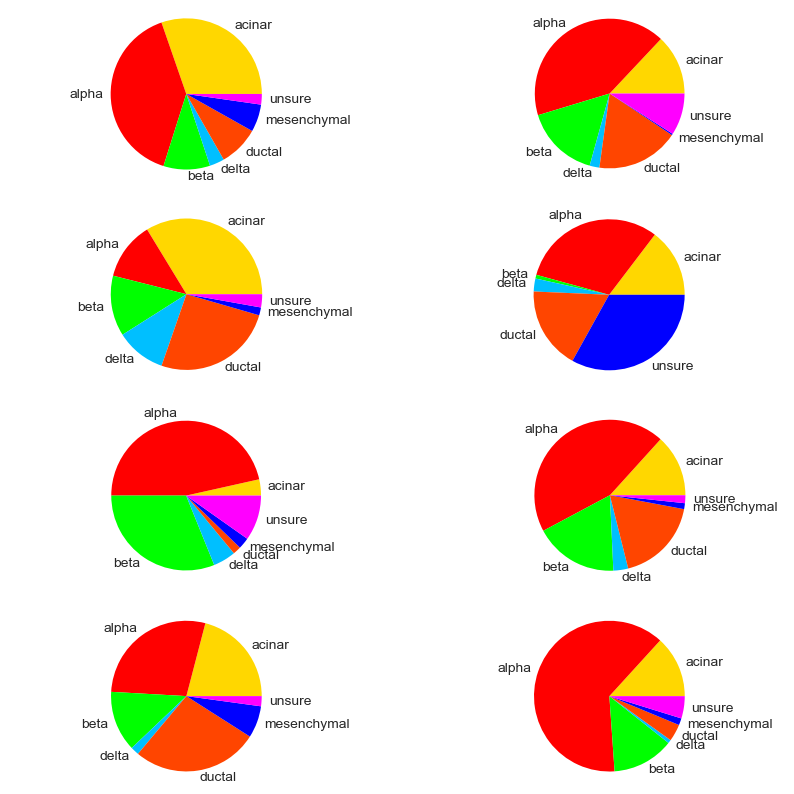

In [168]:
#円グラフを作成
plt.style.use('default')
sns.set()

colors = ["gold","red","lime","deepskyblue","orangered","blue","fuchsia"]
fig = plt.figure(figsize=(10,10))

freq_list = [cell_type_freq_01,cell_type_freq_05,cell_type_freq_06,cell_type_freq_21,cell_type_freq_22,cell_type_freq_38,cell_type_freq_44,cell_type_freq_54]
for i,f in enumerate(freq_list):
    ax = fig.add_subplot(4,2,i+1)
    fs = f.sort_index()
    print(fs.index)
    ax.pie(fs,labels = fs.index,colors = colors)
    ax.axis("equal")
plt.show()

In [173]:
tsne_out_2_cell_type = pd.concat([tsne_out_2,cell_type],axis=1)
tsne_sort = tsne_out_2_cell_type.sort_values("cell_type")
tsne_sort

1          2 cell_type
GSM2173517_44 -10.537848 -19.386953    acinar
GSM2172408_38   6.014480  17.817118    acinar
GSM2173486_44 -15.514574  -5.932470    acinar
GSM2173480_44  -8.820045  21.559700    acinar
GSM2173476_44 -10.350223 -23.965160    acinar
GSM2173474_44 -15.787262  -8.873466    acinar
GSM2173472_44 -13.179266 -23.447062    acinar
GSM2172415_38   6.422734  17.591522    acinar
GSM2172416_38   6.481568  19.612835    acinar
GSM2173469_44  -7.264180  20.537916    acinar
GSM2173468_44 -14.322811  -8.362733    acinar
GSM2173467_44 -11.244823 -23.894625    acinar
GSM2172420_38   5.815077  20.073587    acinar
GSM2173466_44  -8.794219 -22.250137    acinar
GSM2173465_44 -11.087392 -22.970352    acinar
GSM2173464_44  -8.755721 -20.381001    acinar
GSM2172407_38   7.733127  18.623699    acinar
GSM2173462_44  -7.986086  20.787779    acinar
GSM2173488_44 -12.784544 -23.747036    acinar
GSM2173492_44 -10.783043 -22.987215    acinar
GSM2173518_44 -11.301208 -21.734516    acinar
GSM2173516_44 -10.714787  23.074062    acinar
GSM2173513_44  -5.571485 -21.070724    acinar
GSM2173511_44  -7.339179 -19.863876    acinar
GSM2173510_44 -16.499716  -9.470409    acinar
GSM2173508_44  -9.702579  20.322134    acinar
GSM2173506_44  -9.466577 -18.035788    acinar
GSM2173505_44 -11.838947 -15.878212    acinar
GSM2173501_44  -7.623594 -20.980263    acinar
GSM2173500_44 -12.649507 -24.627087    acinar
...                  ...        ...       ...
GSM2172226_21 -30.348080   1.327834    unsure
GSM2173059_05  24.395449   3.304298    unsure
GSM2173068_05  26.677504  17.626827    unsure
GSM2172103_21 -28.099024  -1.393250    unsure
GSM2172104_21 -31.141413  -5.393736    unsure
GSM2172105_21 -29.304630  -2.333927    unsure
GSM2173585_05  16.594086  -6.766054    unsure
GSM2172098_21 -30.074663  -3.555462    unsure
GSM2172089_21 -28.928745  -2.564104    unsure
GSM2172088_21 -25.240561 -10.111702    unsure
GSM2172234_21 -29.477221  -0.365333    unsure
GSM2172247_21 -28.548988   0.591669    unsure
GSM2173947_54  -9.155379 -14.172528    unsure
GSM2174184_22  11.558929 -15.853215    unsure
GSM2174183_22  34.916893   1.425787    unsure
GSM2172243_21 -25.058933   0.411328    unsure
GSM2174180_22  -2.988875  12.971735    unsure
GSM2172078_21 -31.266535  -0.184250    unsure
GSM2174178_22  -3.655309  14.847304    unsure
GSM2172242_21 -26.296228  -0.129855    unsure
GSM2173019_05  25.522501  19.239975    unsure
GSM2172081_21 -31.836016  -3.282783    unsure
GSM2172082_21 -29.301886  -8.649822    unsure
GSM2172083_21 -30.838274  -2.367023    unsure
GSM2172354_21 -25.541044  -0.750272    unsure
GSM2174163_22  21.699444   2.054097    unsure
GSM2172356_21 -26.277328  -2.587506    unsure
GSM2172087_21 -31.095381  -4.493083    unsure
GSM2172349_21 -28.810059  -1.202095    unsure
GSM2172261_21 -26.585434  -1.145665    unsure

[2544 rows x 3 columns]

In [178]:
#cell_typeのグループの位置を調べる
seperation = []
celltype = []
for line in range(0,len(tsne_sort)-1):
    if tsne_sort.iloc[line,2] != tsne_sort.iloc[line+1,2]:
        seperation.append(line)
        celltype.append(tsne_sort.iloc[line,2])
    
group = dict(zip(seperation,celltype))
 
group

{410: 'acinar',
 1408: 'alpha',
 1756: 'beta',
 1839: 'delta',
 2228: 'ductal',
 2281: 'mesenchymal'}

In [193]:
#alpha細胞のみで学習させるため抽出しておく
alpha_sample = tsne_sort.iloc[411:1409,:]
alpha_sample_index = alpha_sample.index

alpha_rnaseq_df = rnaseq_df.loc[list(alpha_sample_index)]
alpha_rnaseq_df

alpha_age_label = age_label.loc[list(alpha_sample_index)]
alpha_age_label

age_label
GSM2173025_05        5.0
GSM2173027_05        5.0
GSM2173024_05        5.0
GSM2173023_05        5.0
GSM2173065_05        5.0
GSM2173049_05        5.0
GSM2174334_22       22.0
GSM2173020_05        5.0
GSM2173053_05        5.0
GSM2173403_05        5.0
GSM2173407_05        5.0
GSM2173422_05        5.0
GSM2173014_05        5.0
GSM2173423_05        5.0
GSM2173021_05        5.0
GSM2173401_05        5.0
GSM2173397_05        5.0
GSM2173028_05        5.0
GSM2173040_05        5.0
GSM2173067_05        5.0
GSM2173069_05        5.0
GSM2173041_05        5.0
GSM2173336_05        5.0
GSM2173042_05        5.0
GSM2173035_05        5.0
GSM2173339_05        5.0
GSM2173341_05        5.0
GSM2174333_22       22.0
GSM2174335_22       22.0
GSM2174332_22       22.0
...                  ...
GSM2172845_38       38.0
GSM2172728_38       38.0
GSM2172844_38       38.0
GSM2172023_21       21.0
GSM2172067_21       21.0
GSM2172025_21       21.0
GSM2172727_38       38.0
GSM2172725_38       38.0
GSM2172029_21       21.0
GSM2172731_38       38.0
GSM2172733_38       38.0
GSM2172538_38       38.0
GSM2172030_21       21.0
GSM2172846_38       38.0
GSM2172433_38       38.0
GSM2172848_38       38.0
GSM2172738_38       38.0
GSM2172475_38       38.0
GSM2172735_38       38.0
GSM2172734_38       38.0
GSM2172481_38       38.0
GSM2172036_21       21.0
GSM2172539_38       38.0
GSM2172729_38       38.0
GSM2172066_21       21.0
GSM2172837_38       38.0
GSM2172032_21       21.0
GSM2172031_21       21.0
GSM2172540_38       38.0
GSM2172034_21       21.0

[998 rows x 1 columns]

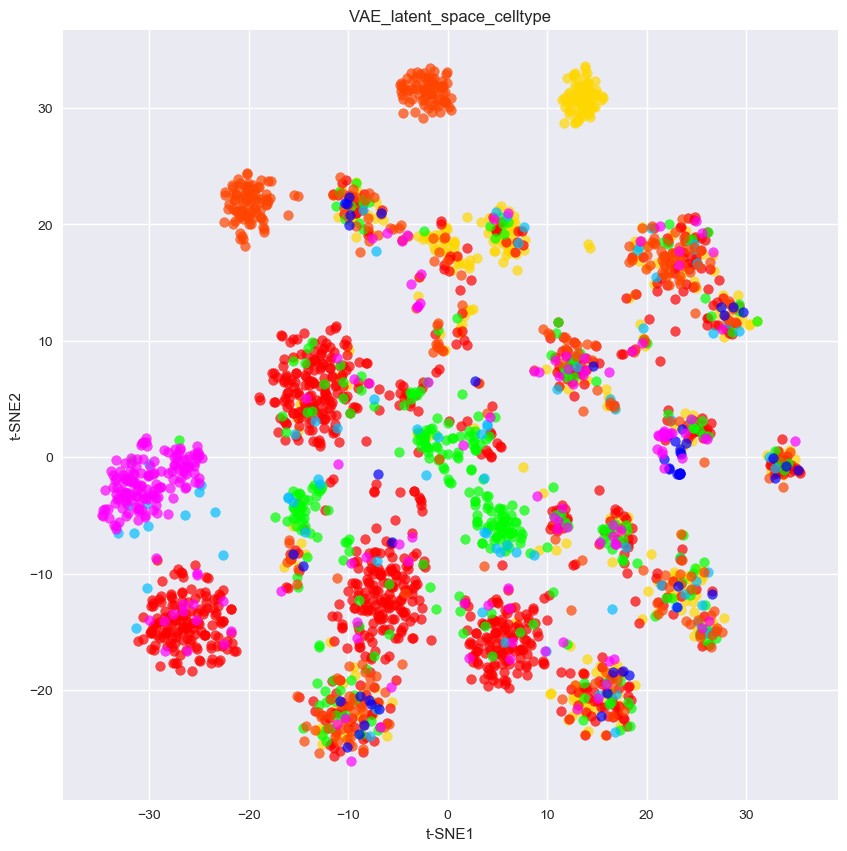

In [179]:
#潜在変数を細胞型で色分けしてみる
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('VAE_latent_space_celltype')
ax = fig.add_subplot(1,1,1)

ax.scatter(tsne_sort.iloc[0:411,0], tsne_sort.iloc[0:411, 1],c = "gold",label = "acinar",alpha=0.7)
ax.scatter(tsne_sort.iloc[411:1409,0], tsne_sort.iloc[411:1409, 1],c = "red",label = "alpha",alpha=0.7)
ax.scatter(tsne_sort.iloc[1409:1757,0],tsne_sort.iloc[1409:1757, 1],c = "lime",label = "beta",alpha=0.7)
ax.scatter(tsne_sort.iloc[1757:1840,0],tsne_sort.iloc[1757:1840, 1],c = "deepskyblue",label = "delta",alpha=0.7)
ax.scatter(tsne_sort.iloc[1840:2229,0], tsne_sort.iloc[1840:2229, 1],c = "orangered",label = "ductal",alpha=0.7)
ax.scatter(tsne_sort.iloc[2229:2282,0],tsne_sort.iloc[2229:2282, 1],c = "blue",label = "masenchymal",alpha=0.7)
ax.scatter(tsne_sort.iloc[2282:len(tsne_sort),0], tsne_sort.iloc[2282:len(tsne_sort), 1],c = "fuchsia",label = "unsure",alpha=0.7)
#青から緑色になる程年齢が高くなっていく
#ax.collections[0].colorbar.minorticks_on()

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')


plt.show()


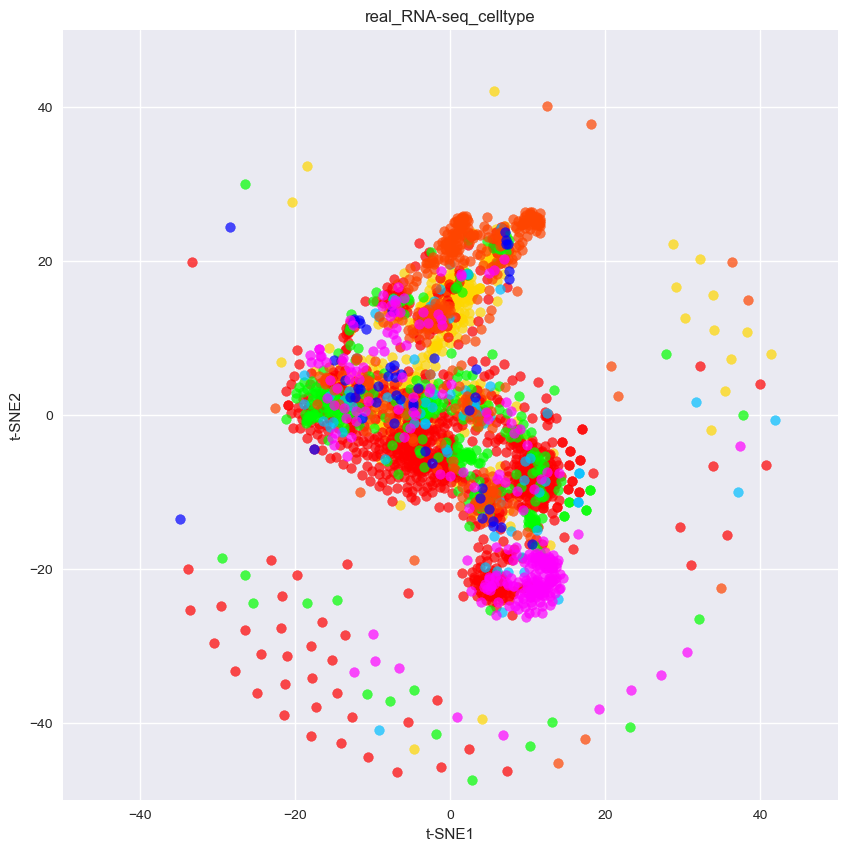

In [8]:
#RNA-seqデータのt-SNE埋め込みの様子を細胞型について色分けする
tsne_out_real_sort = pd.concat([tsne_out_real,cell_type],axis=1)
tsne_out_real_sort = tsne_out_real_sort.sort_values("cell_type")


plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('real_RNA-seq_celltype')
ax = fig.add_subplot(1,1,1)

ax.scatter(tsne_out_real_sort.iloc[0:411,0], tsne_out_real_sort.iloc[0:411, 1],c = "gold",label = "acinar",alpha=0.7)
ax.scatter(tsne_out_real_sort.iloc[411:1409,0], tsne_out_real_sort.iloc[411:1409, 1],c = "red",label = "alpha",alpha=0.7)
ax.scatter(tsne_out_real_sort.iloc[1409:1757,0],tsne_out_real_sort.iloc[1409:1757, 1],c = "lime",label = "beta",alpha=0.7)
ax.scatter(tsne_out_real_sort.iloc[1757:1840,0],tsne_out_real_sort.iloc[1757:1840, 1],c = "deepskyblue",label = "delta",alpha=0.7)
ax.scatter(tsne_out_real_sort.iloc[1840:2229,0], tsne_out_real_sort.iloc[1840:2229, 1],c = "orangered",label = "ductal",alpha=0.7)
ax.scatter(tsne_out_real_sort.iloc[2229:2282,0],tsne_out_real_sort.iloc[2229:2282, 1],c = "blue",label = "masenchymal",alpha=0.7)
ax.scatter(tsne_out_real_sort.iloc[2282:len(tsne_out_real_sort),0], tsne_out_real_sort.iloc[2282:len(tsne_out_real_sort), 1],c = "fuchsia",label = "unsure",alpha=0.7)

plt.xlim([-50,50])
plt.ylim([-50,50])

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')


plt.show()


In [198]:
#xのトレーニング・テストデータの作成
#データの10%をテストデータセットに分割する
test_set_percent = 0.1
alpha_rnaseq_test_df = alpha_rnaseq_df.sample(frac=test_set_percent)

alpha_rnaseq_train_df = alpha_rnaseq_df.drop(alpha_rnaseq_test_df.index)

#yのトレーニング・テストデータの作成
alpha_rnaseq_test_df_index = list(alpha_rnaseq_test_df.index)
alpha_y_label_test = alpha_age_label.loc[alpha_rnaseq_test_df_index]
alpha_y_label_train = alpha_age_label.drop(alpha_rnaseq_test_df.index)

In [224]:
#VAEに渡すためにファイルを保存
alpha_rnaseq_df.to_csv("alpha_rnaseq.txt",index =True,header=True,sep='\t')
alpha_rnaseq_test_df.to_csv("alpha_rnaseq_test.txt",index =True,header=True,sep='\t')
alpha_rnaseq_train_df.to_csv("alpha_rnaseq_train.txt",index =True,header=True,sep='\t')
alpha_age_label.to_csv("alpha_age_label.txt",index =True,header=True,sep='\t')
alpha_y_label_test.to_csv("alpha_y_label_test.txt",index =True,header=True,sep='\t')
alpha_y_label_train.to_csv("alpha_y_label_train.txt",index =True,header=True,sep='\t')

In [203]:
#alpha細胞のみでCVAEを学習させてみる
hist = cvae.fit([np.array(alpha_rnaseq_train_df),np.array(alpha_y_label_train)],np.array(alpha_rnaseq_train_df),shuffle=True,epochs=epochs,verbose=0,batch_size=batch_size,validation_data=([np.array(alpha_rnaseq_test_df),np.array(alpha_y_label_test)],np.array(alpha_rnaseq_test_df)),callbacks=[WarmUpCallback(beta, kappa),TQDMNotebookCallback(leave_inner=True, leave_outer=True)])




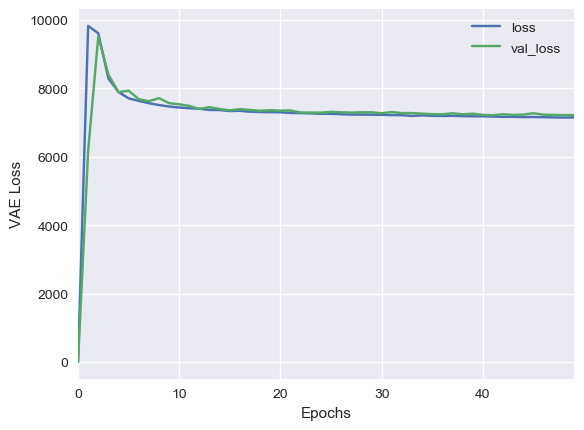

In [204]:
# Visualize training performance
alpha_history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('/Users/yokosaka/Desktop/python/','my_alpha_onehidden_cvae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [205]:
alpha_encoder = Model([rnaseq_input,y_label_input], z)

In [206]:
# 隠れ層にalpha_rnaseqデータを潜在変数としてエンコードする。
encoded_alpha_rnaseq_df = alpha_encoder.predict_on_batch([alpha_rnaseq_df,alpha_age_label])
encoded_alpha_rnaseq_df = pd.DataFrame(encoded_alpha_rnaseq_df, index=alpha_rnaseq_df.index)
encoded_alpha_rnaseq_df

0         1         2         3         4         5   \
GSM2173025_05  1.205071  0.769015  0.214060  0.996083  1.893751  2.682802   
GSM2173027_05 -1.342930  1.337249  0.380115 -0.124823  0.207221  2.862138   
GSM2173024_05  3.757945  0.045761  1.062953  1.764512  0.998589  3.209462   
GSM2173023_05  2.325694  1.455803  0.237813 -1.041965  4.128601  2.362330   
GSM2173065_05  1.296962  1.012344  0.472248 -0.499919  0.583905  2.754988   
GSM2173049_05  0.777967 -1.735478  0.443378 -0.166219 -0.735721 -0.732242   
GSM2174334_22 -0.332692  1.408972  0.644437  0.829291 -0.958495 -1.528877   
GSM2173020_05  3.766586  2.111883 -0.619781  1.410450  0.588565  2.413351   
GSM2173053_05  3.625349  1.188622  0.674906 -1.098342  1.653231  2.243457   
GSM2173403_05  4.773394 -0.498488 -1.424664 -0.124790 -0.134478  0.024593   
GSM2173407_05  3.862225 -0.361996 -1.010685  2.087630 -1.062216  2.400906   
GSM2173422_05  2.112179 -0.461843  0.216147  0.498197 -2.965194  5.077231   
GSM2173014_05  4.243798  5.389729  0.995855 -0.460111 -0.137440  0.043739   
GSM2173423_05  2.643382  0.096310 -0.260443  3.454222 -0.443362  2.516634   
GSM2173021_05  0.743984  1.404399 -1.407067 -0.556866  1.072147  2.176544   
GSM2173401_05  5.462036  0.357824  0.186249  0.195885 -1.647958  3.893652   
GSM2173397_05  2.664009 -1.140907 -0.065983  5.843941  0.917798  2.152534   
GSM2173028_05  2.535640  1.146190 -0.248508  2.967441  1.524967  2.988340   
GSM2173040_05  1.614796  1.630182  1.710713 -0.055475  0.965852  2.036465   
GSM2173067_05  2.245660  1.760677  0.713132  0.425934  0.062863  1.475691   
GSM2173069_05  2.578181 -0.720371 -0.231140 -0.605801  1.487242  1.324364   
GSM2173041_05  3.747514  2.938277  0.640411 -0.865312  1.810319  4.388541   
GSM2173336_05  1.888239  1.129575 -1.370576  3.461497  0.732996  6.111567   
GSM2173042_05  7.618878  1.098433  1.531876  0.665389  1.399506  2.169844   
GSM2173035_05  2.820493  3.135665 -1.131997  1.472116  0.303326  2.118494   
GSM2173339_05  6.049679 -0.417891 -0.650450  4.624310  0.884099  1.579050   
GSM2173341_05  3.698645  1.642231  0.812442  3.342000  0.113730  3.299558   
GSM2174333_22 -0.758796 -1.208513  1.741627  0.813783  1.070107 -1.341062   
GSM2174335_22  0.158881  3.616906  3.741678 -0.730836  0.043853  1.267118   
GSM2174332_22 -0.172726  2.976584  1.327360  1.133331  3.593659 -2.653309   
...                 ...       ...       ...       ...       ...       ...   
GSM2172845_38  0.975860 -0.686954  0.625139  2.376666  0.367110 -0.113632   
GSM2172728_38  0.435897 -0.475659 -0.474457  4.907441  1.060555 -0.082646   
GSM2172844_38 -1.539499 -0.676464  2.121889  3.982064 -1.667105 -1.056137   
GSM2172023_21 -0.959565 -0.761884  1.534074  0.278017 -0.615889  0.639076   
GSM2172067_21  0.733716  2.485290 -1.543044 -0.862752 -1.082749  2.349072   
GSM2172025_21 -0.031774 -1.433026  0.674555  0.904551  0.755499  0.505622   
GSM2172727_38  0.768227  0.502072 -1.098698  4.279712  2.295088  0.275796   
GSM2172725_38 -0.838536 -0.150135  0.831273  0.388453  0.401378 -0.725459   
GSM2172029_21  0.688608  0.072966  0.821317 -0.880030 -1.065507 -0.412334   
GSM2172731_38  0.084593 -0.147528  2.372411  1.825926 -0.279569  0.938210   
GSM2172733_38  0.396008  3.150749  1.267753  5.227607  0.420137  0.536432   
GSM2172538_38  0.385429  0.545353  1.134440  2.993118 -0.196870 -1.003172   
GSM2172030_21 -0.188529 -0.895424  4.093177  1.958786  0.883139  0.039103   
GSM2172846_38 -0.049947 -1.569283  0.449851  3.861804 -0.066131  0.766067   
GSM2172433_38  0.314613  0.139558 -1.052505  0.000589  0.093364  3.838080   
GSM2172848_38 -1.195588  1.751704 -0.031342  4.567559 -0.022031  0.314512   
GSM2172738_38 -0.030468 -0.832824 -0.992206  2.785003  1.202855 -0.171356   
GSM2172475_38  0.922510  1.419367 -0.078494  0.750880  0.478005  3.920243   
GSM2172735_38  0.082318 -0.528494  0.488146 -0.433585 -0.456181  2.134725   
GSM2172734_38 -0.143809 -0.337212  1.900434 -0.352699 -0.371604 -0.541697   
GSM2172481_38  0.

In [208]:
encoded_alpha_rnaseq_df.columns.name = 'sample_id'
encoded_alpha_rnaseq_df.columns = encoded_alpha_rnaseq_df.columns + 1
encoded_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_alpha_cvae_encoded_rnaseq_onehidden_warmup_batchnorm.tsv')
encoded_alpha_rnaseq_df.to_csv(encoded_file, sep='\t')
encoded_alpha_rnaseq_df

sample_id           1         2         3         4         5         6    \
GSM2173025_05  1.205071  0.769015  0.214060  0.996083  1.893751  2.682802   
GSM2173027_05 -1.342930  1.337249  0.380115 -0.124823  0.207221  2.862138   
GSM2173024_05  3.757945  0.045761  1.062953  1.764512  0.998589  3.209462   
GSM2173023_05  2.325694  1.455803  0.237813 -1.041965  4.128601  2.362330   
GSM2173065_05  1.296962  1.012344  0.472248 -0.499919  0.583905  2.754988   
GSM2173049_05  0.777967 -1.735478  0.443378 -0.166219 -0.735721 -0.732242   
GSM2174334_22 -0.332692  1.408972  0.644437  0.829291 -0.958495 -1.528877   
GSM2173020_05  3.766586  2.111883 -0.619781  1.410450  0.588565  2.413351   
GSM2173053_05  3.625349  1.188622  0.674906 -1.098342  1.653231  2.243457   
GSM2173403_05  4.773394 -0.498488 -1.424664 -0.124790 -0.134478  0.024593   
GSM2173407_05  3.862225 -0.361996 -1.010685  2.087630 -1.062216  2.400906   
GSM2173422_05  2.112179 -0.461843  0.216147  0.498197 -2.965194  5.077231   
GSM2173014_05  4.243798  5.389729  0.995855 -0.460111 -0.137440  0.043739   
GSM2173423_05  2.643382  0.096310 -0.260443  3.454222 -0.443362  2.516634   
GSM2173021_05  0.743984  1.404399 -1.407067 -0.556866  1.072147  2.176544   
GSM2173401_05  5.462036  0.357824  0.186249  0.195885 -1.647958  3.893652   
GSM2173397_05  2.664009 -1.140907 -0.065983  5.843941  0.917798  2.152534   
GSM2173028_05  2.535640  1.146190 -0.248508  2.967441  1.524967  2.988340   
GSM2173040_05  1.614796  1.630182  1.710713 -0.055475  0.965852  2.036465   
GSM2173067_05  2.245660  1.760677  0.713132  0.425934  0.062863  1.475691   
GSM2173069_05  2.578181 -0.720371 -0.231140 -0.605801  1.487242  1.324364   
GSM2173041_05  3.747514  2.938277  0.640411 -0.865312  1.810319  4.388541   
GSM2173336_05  1.888239  1.129575 -1.370576  3.461497  0.732996  6.111567   
GSM2173042_05  7.618878  1.098433  1.531876  0.665389  1.399506  2.169844   
GSM2173035_05  2.820493  3.135665 -1.131997  1.472116  0.303326  2.118494   
GSM2173339_05  6.049679 -0.417891 -0.650450  4.624310  0.884099  1.579050   
GSM2173341_05  3.698645  1.642231  0.812442  3.342000  0.113730  3.299558   
GSM2174333_22 -0.758796 -1.208513  1.741627  0.813783  1.070107 -1.341062   
GSM2174335_22  0.158881  3.616906  3.741678 -0.730836  0.043853  1.267118   
GSM2174332_22 -0.172726  2.976584  1.327360  1.133331  3.593659 -2.653309   
...                 ...       ...       ...       ...       ...       ...   
GSM2172845_38  0.975860 -0.686954  0.625139  2.376666  0.367110 -0.113632   
GSM2172728_38  0.435897 -0.475659 -0.474457  4.907441  1.060555 -0.082646   
GSM2172844_38 -1.539499 -0.676464  2.121889  3.982064 -1.667105 -1.056137   
GSM2172023_21 -0.959565 -0.761884  1.534074  0.278017 -0.615889  0.639076   
GSM2172067_21  0.733716  2.485290 -1.543044 -0.862752 -1.082749  2.349072   
GSM2172025_21 -0.031774 -1.433026  0.674555  0.904551  0.755499  0.505622   
GSM2172727_38  0.768227  0.502072 -1.098698  4.279712  2.295088  0.275796   
GSM2172725_38 -0.838536 -0.150135  0.831273  0.388453  0.401378 -0.725459   
GSM2172029_21  0.688608  0.072966  0.821317 -0.880030 -1.065507 -0.412334   
GSM2172731_38  0.084593 -0.147528  2.372411  1.825926 -0.279569  0.938210   
GSM2172733_38  0.396008  3.150749  1.267753  5.227607  0.420137  0.536432   
GSM2172538_38  0.385429  0.545353  1.134440  2.993118 -0.196870 -1.003172   
GSM2172030_21 -0.188529 -0.895424  4.093177  1.958786  0.883139  0.039103   
GSM2172846_38 -0.049947 -1.569283  0.449851  3.861804 -0.066131  0.766067   
GSM2172433_38  0.314613  0.139558 -1.052505  0.000589  0.093364  3.838080   
GSM2172848_38 -1.195588  1.751704 -0.031342  4.567559 -0.022031  0.314512   
GSM2172738_38 -0.030468 -0.832824 -0.992206  2.785003  1.202855 -0.171356   
GSM2172475_38  0.922510  1.419367 -0.078494  0.750880  0.478005  3.920243   
GSM2172735_38  0.082318 -0.528494  0.488146 -0.433585 -0.456181  2.134725   
GSM2172734_38 -0.143809 -0.337212  1.900434 -0.352699 -0.371604 -0.541697

In [209]:
encoder_model_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_alpha_encoder_onehidden_vae.hdf5')
alpha_encoder.save(encoder_model_file)

In [225]:
##Decoder (generative) model

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim + 1, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
alpha_decoder = Model(decoder_input, _x_decoded_mean)

In [226]:
decoder_model_file = os.path.join('/Users/yokosaka/Desktop/python/', 'my_cvae_1decoder_onehidden_vae.hdf5')
alpha_decoder.save(decoder_model_file)

In [220]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,learning_rate=300, n_iter=400)
tsne_out_alpha = tsne.fit_transform(encoded_alpha_rnaseq_df)
tsne_out_alpha = pd.DataFrame(tsne_out_alpha, columns=['1', '2'])
tsne_out_alpha.index = encoded_alpha_rnaseq_df.index

In [221]:

tsne_out_alpha = pd.concat([tsne_out_alpha,alpha_age_label],axis=1)
tsne_out_alpha = tsne_out_alpha.sort_values("age_label")
print(tsne_out_alpha)

#年齢のグループの位置を調べる
seperation = []
celltype = []
for line in range(0,len(tsne_out_alpha)-1):
    if tsne_out_alpha.iloc[line,2] != tsne_out_alpha.iloc[line+1,2]:
        seperation.append(line)
        celltype.append(tsne_out_alpha.iloc[line,2])
    
aggroup = dict(zip(seperation,celltype))
 
aggroup

                       1          2  age_label
GSM2172788_01  20.297966 -11.567186        1.0
GSM2173706_01  31.420834   5.664575        1.0
GSM2172813_01  23.235556 -14.506059        1.0
GSM2172812_01  22.462404 -12.677742        1.0
GSM2172811_01  20.653227 -13.759599        1.0
GSM2172810_01  22.063202 -12.541200        1.0
GSM2172774_01  22.179348 -12.493262        1.0
GSM2172776_01  24.556940 -12.090895        1.0
GSM2172800_01  19.505043 -13.373319        1.0
GSM2173735_01  30.479158   5.504235        1.0
GSM2172799_01  20.428083 -14.272653        1.0
GSM2173712_01  21.990395 -11.329538        1.0
GSM2172798_01  23.611368 -13.798839        1.0
GSM2172815_01  22.194481 -13.519034        1.0
GSM2173730_01  30.564919   6.034708        1.0
GSM2172796_01  23.040890 -13.089874        1.0
GSM2172795_01  19.703590 -14.770378        1.0
GSM2172793_01   6.047095   3.028213        1.0
GSM2173728_01  30.158419  -1.764901        1.0
GSM2172792_01  23.672310 -11.270811        1.0
GSM2173724_01

{87: 1.0, 225: 5.0, 247: 6.0, 404: 21.0, 537: 22.0, 748: 38.0, 826: 44.0}

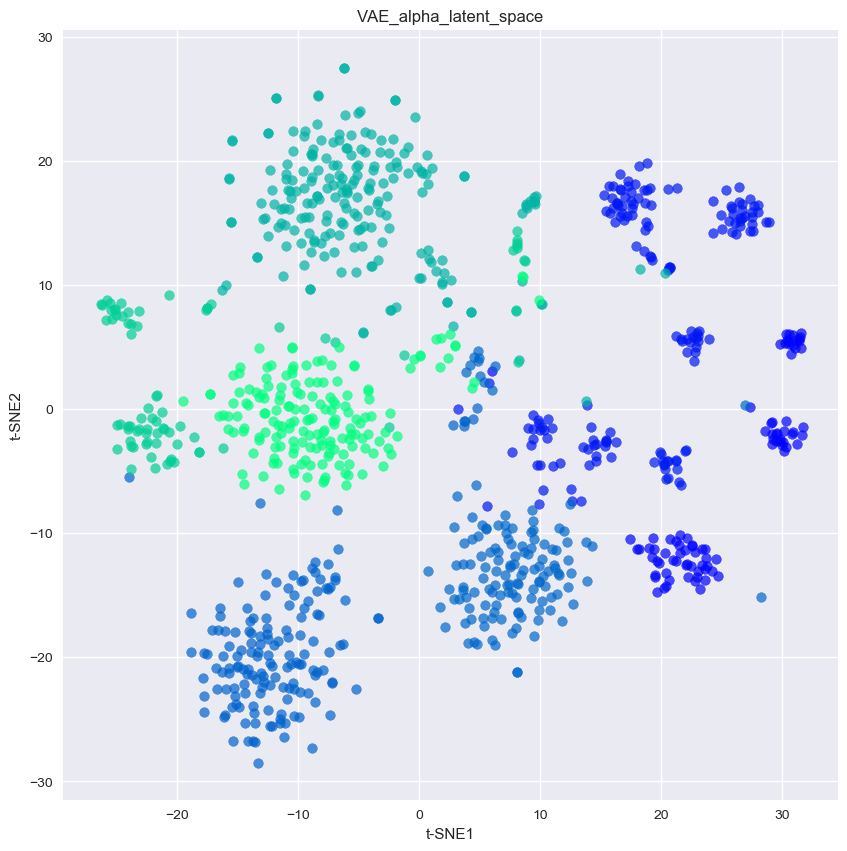

In [222]:
plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('CVAE_alpha_latent_space')
ax = fig.add_subplot(1,1,1)

ax.scatter(tsne_out_alpha.iloc[0:88,0], tsne_out_alpha.iloc[0:88, 1],c = plt.cm.winter(1/54),label = "1year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[88:226,0], tsne_out_alpha.iloc[88:226, 1],c = plt.cm.winter(5/54),label = "5year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[226:248,0],tsne_out_alpha.iloc[226:248, 1],c = plt.cm.winter(6/54),label = "6year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[248:405,0],tsne_out_alpha.iloc[248:405, 1],c = plt.cm.winter(21/54),label = "21year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[405:538,0], tsne_out_alpha.iloc[405:538, 1],c = plt.cm.winter(22/54),label = "22year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[538:749,0],tsne_out_alpha.iloc[538:749, 1],c = plt.cm.winter(38/54),label = "38year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[749:827,0], tsne_out_alpha.iloc[749:827, 1],c = plt.cm.winter(44/54),label = "44year",alpha=0.7)
ax.scatter(tsne_out_alpha.iloc[827:len(tsne_out_alpha),0], tsne_out_alpha.iloc[827:len(tsne_out_alpha), 1],c = plt.cm.winter(54/54),label = "54year",alpha=0.7)
#青から緑色になる程年齢が高くなっていく
#ax.collections[0].colorbar.minorticks_on()

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')


plt.show()

In [228]:
alpha_z_c = pd.concat([encoded_alpha_rnaseq_df,alpha_age_label],axis = 1)

input_alpha_rnaseq_reconstruct = alpha_decoder.predict(np.array(alpha_z_c))
input_alpha_rnaseq_reconstruct = pd.DataFrame(input_alpha_rnaseq_reconstruct, index=alpha_rnaseq_df.index,columns=alpha_rnaseq_df.columns)
input_alpha_rnaseq_reconstruct

1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1       A2M  \
GSM2173025_05     0.001932  0.052872  0.001005  0.038041  0.004939  0.008863   
GSM2173027_05     0.003674  0.200809  0.002534  0.022794  0.014800  0.000267   
GSM2173024_05     0.003259  0.031925  0.001492  0.018648  0.017206  0.000526   
GSM2173023_05     0.001072  0.039339  0.000356  0.043362  0.007250  0.000486   
GSM2173065_05     0.005944  0.030584  0.000702  0.009163  0.000299  0.430767   
GSM2173049_05     0.004647  0.072920  0.001373  0.037339  0.003045  0.001581   
GSM2174334_22     0.014303  0.172179  0.010961  0.252545  0.004430  0.005272   
GSM2173020_05     0.004916  0.089255  0.001755  0.072176  0.030669  0.002055   
GSM2173053_05     0.002890  0.074986  0.003056  0.099784  0.014736  0.001211   
GSM2173403_05     0.006076  0.016524  0.000392  0.011105  0.056635  0.030098   
GSM2173407_05     0.016977  0.017753  0.003521  0.015335  0.005510  0.003850   
GSM2173422_05     0.002237  0.009829  0.000394  0.009105  0.002094  0.002377   
GSM2173014_05     0.001408  0.048204  0.004419  0.103756  0.032711  0.000417   
GSM2173423_05     0.005054  0.010610  0.000925  0.021863  0.008261  0.009518   
GSM2173021_05     0.003647  0.079945  0.001676  0.065157  0.011866  0.000730   
GSM2173401_05     0.004076  0.019752  0.000251  0.014299  0.004976  0.003713   
GSM2173397_05     0.002729  0.021780  0.003568  0.014938  0.005633  0.002974   
GSM2173028_05     0.002272  0.020681  0.000433  0.018752  0.000646  0.003750   
GSM2173040_05     0.008983  0.178377  0.003800  0.123284  0.001249  0.000772   
GSM2173067_05     0.007366  0.051203  0.002957  0.096180  0.018566  0.001717   
GSM2173069_05     0.002542  0.099774  0.006314  0.102006  0.015506  0.002849   
GSM2173041_05     0.000959  0.033723  0.000395  0.036302  0.007977  0.001508   
GSM2173336_05     0.002337  0.008861  0.000256  0.015654  0.000525  0.002403   
GSM2173042_05     0.000722  0.006883  0.000176  0.009842  0.020577  0.000288   
GSM2173035_05     0.007591  0.061117  0.001439  0.036720  0.011940  0.008264   
GSM2173339_05     0.002470  0.017007  0.000363  0.012293  0.011302  0.002797   
GSM2173341_05     0.003390  0.026673  0.001011  0.018252  0.004930  0.000856   
GSM2174333_22     0.008508  0.101468  0.016715  0.347159  0.003426  0.001323   
GSM2174335_22     0.002858  0.112619  0.003971  0.236814  0.002300  0.000244   
GSM2174332_22     0.011992  0.184683  0.010341  0.326349  0.010298  0.003726   
...                    ...       ...       ...       ...       ...       ...   
GSM2172845_38     0.003325  0.199721  0.018984  0.221717  0.002366  0.000119   
GSM2172728_38     0.007735  0.135786  0.022108  0.103361  0.005689  0.002264   
GSM2172844_38     0.002453  0.176181  0.027326  0.193706  0.004971  0.001340   
GSM2172023_21     0.011947  0.082078  0.020868  0.412476  0.018717  0.001114   
GSM2172067_21     0.008351  0.067126  0.002839  0.122730  0.003109  0.008648   
GSM2172025_21     0.008371  0.084856  0.023708  0.166477  0.001734  0.000242   
GSM2172727_38     0.004131  0.129981  0.034449  0.161715  0.001432  0.000493   
GSM2172725_38     0.003193  0.184981  0.026085  0.167931  0.003669  0.002752   
GSM2172029_21     0.010011  0.078790  0.066229  0.290574  0.036861  0.002835   
GSM2172731_38     0.002818  0.189106  0.016351  0.167021  0.008055  0.002080   
GSM2172733_38     0.002107  0.120652  0.018335  0.121711  0.000904  0.000381   
GSM2172538_38     0.009699  0.313395  0.041076  0.304784  0.002256  0.001627   
GSM2172030_21     0.005172  0.055455  0.017400  0.264265  0.004889  0.000243   
GSM2172846_38     0.004336  0.140035  0.022449  0.106985  0.002249  0.002689   
GSM2172433_38     0.000398  0.014990  0.000421  0.045672  0.000210  0.004387   
GSM2172848_38     0.003777  0.221531  0.019372  0.186446  0.001984  0.000552   
GSM2172738_38     0.002428  0.208719  0.008312  0.095319  0.000621  0.000166   
GSM2172475_38     0.000417  0.028538  0.003243  0.079794  0.001059  0.000289   
GSM2172735_38  

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,learning_rate=300, n_iter=400)
tsne_real_alpha = tsne.fit_transform(alpha_rnaseq_df)
tsne_real_alpha = pd.DataFrame(tsne_real_alpha, columns=['1', '2'])
tsne_real_alpha.index = alpha_rnaseq_df.index

#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,learning_rate=300, n_iter=400)
tsne_generated_alpha = tsne.fit_transform(input_alpha_rnaseq_reconstruct)
tsne_generated_alpha = pd.DataFrame(tsne_generated_alpha, columns=['1', '2'])
tsne_generated_alpha.index = alpha_rnaseq_df.index

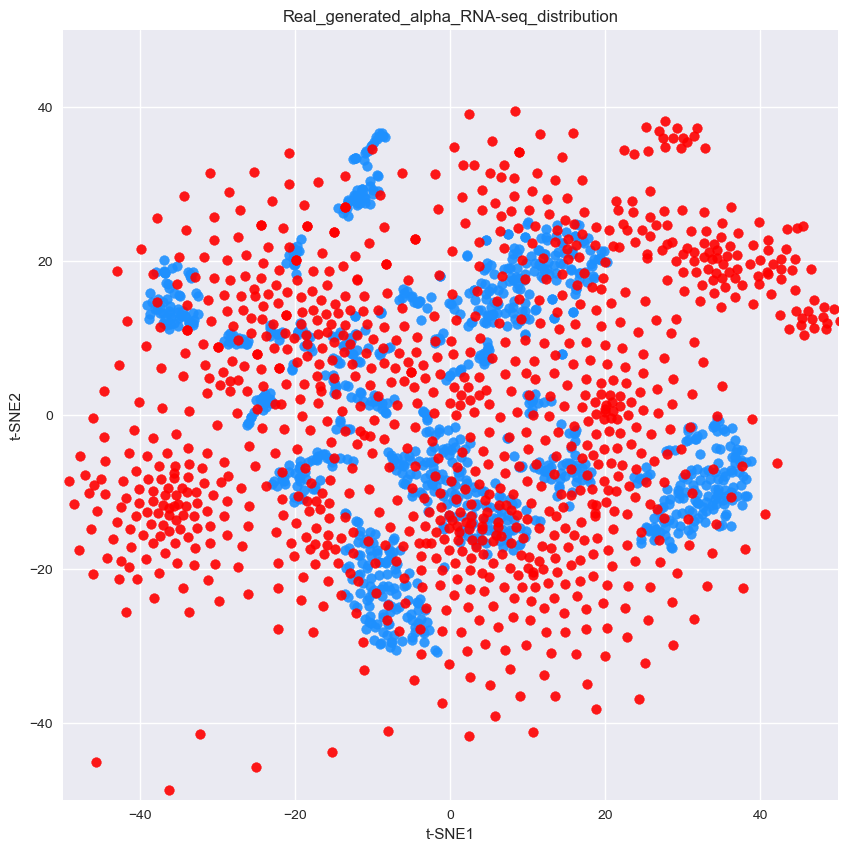

In [230]:

plt.style.use('default')
sns.set()

fig = plt.figure(figsize=(10,10))
plt.title('Real_generated_alpha_RNA-seq_distribution')
ax = fig.add_subplot(1,1,1)
    
ax.scatter(tsne_generated_alpha["1"],tsne_generated_alpha["2"],c ="dodgerblue",alpha = 0.9)
ax.scatter(tsne_real_alpha["1"],tsne_real_alpha["2"],c = "red",alpha = 0.9)

#青から緑色になる程年齢が高くなっていく
#ax.collections[0].colorbar.minorticks_on()

ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')

plt.xlim([-50,50])
plt.ylim([-50,50])

plt.show()

In [185]:
CASP1 = pd.concat([rnaseq_df["CASP1"],age_label],axis=1)
CASP1 = CASP1.sort_values("age_label")

CASP1  age_label
GSM2172764_01    0.0        1.0
GSM2173788_01    0.0        1.0
GSM2173789_01    0.0        1.0
GSM2173790_01    0.0        1.0
GSM2173791_01    0.0        1.0
GSM2173792_01    0.0        1.0
GSM2173793_01    0.0        1.0
GSM2173794_01    0.0        1.0
GSM2173795_01    0.0        1.0
GSM2173796_01    0.0        1.0
GSM2173797_01    0.0        1.0
GSM2173798_01    0.0        1.0
GSM2173799_01    0.0        1.0
GSM2173800_01    0.0        1.0
GSM2173801_01    0.0        1.0
GSM2173802_01    0.0        1.0
GSM2173803_01    0.0        1.0
GSM2173804_01    0.0        1.0
GSM2173805_01    0.0        1.0
GSM2173806_01    0.0        1.0
GSM2173807_01    0.0        1.0
GSM2173808_01    0.0        1.0
GSM2173809_01    0.0        1.0
GSM2173810_01    0.0        1.0
GSM2173787_01    0.0        1.0
GSM2173786_01    0.0        1.0
GSM2173785_01    0.0        1.0
GSM2173784_01    0.0        1.0
GSM2173760_01    0.0        1.0
GSM2173761_01    0.0        1.0
...              ...        ...
GSM2174076_54    0.0       54.0
GSM2174075_54    0.0       54.0
GSM2174074_54    0.0       54.0
GSM2174073_54    0.0       54.0
GSM2174072_54    0.0       54.0
GSM2174071_54    0.0       54.0
GSM2174070_54    0.0       54.0
GSM2174069_54    0.0       54.0
GSM2174068_54    0.0       54.0
GSM2174067_54    0.0       54.0
GSM2174066_54    0.0       54.0
GSM2174065_54    0.0       54.0
GSM2174047_54    0.0       54.0
GSM2174064_54    0.0       54.0
GSM2174062_54    0.0       54.0
GSM2174061_54    0.0       54.0
GSM2174060_54    0.0       54.0
GSM2174059_54    0.0       54.0
GSM2174058_54    0.0       54.0
GSM2174057_54    0.0       54.0
GSM2174056_54    0.0       54.0
GSM2174055_54    0.0       54.0
GSM2174054_54    0.0       54.0
GSM2174053_54    0.0       54.0
GSM2174052_54    0.0       54.0
GSM2174051_54    0.0       54.0
GSM2174050_54    0.0       54.0
GSM2174049_54    0.0       54.0
GSM2174063_54    0.0       54.0
GSM2173915_54    0.0       54.0

[2544 rows x 2 columns]

In [196]:
CASP1.describe()

CASP1    age_label
count  2544.000000  2544.000000
mean      0.005524    25.443789
std       0.051072    17.092678
min       0.000000     1.000000
25%       0.000000     6.000000
50%       0.000000    22.000000
75%       0.000000    38.000000
max       0.625904    54.000000

In [ ]:
#ネットワークアーキテクチャーを変更して(層数を増やしてみる)学習してみる


